In [1]:
# Imports & global parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import combinations
import time
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_circles, make_classification
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr, mannwhitneyu, wilcoxon, kruskal, fisher_exact, ttest_1samp, rankdata, linregress, entropy
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
import shap
import lime
import lime.lime_tabular
from pymfe.mfe import MFE
import joblib
import os
import warnings
import matplotlib.ticker as mtick
warnings.filterwarnings("ignore")


# Reproducibility
GLOBAL_SEED = 13
np.random.seed(GLOBAL_SEED)

# Analysis control parameters (adjust for speed/accuracy)
N_POINTS = 1000                 # dataset size
TEST_SIZE = 0.2
N_ANALYZE_INSTANCES = 200      # number of test instances to analyze per dataset (limit for compute)
K_NEIGHBORS = 1               # nearest neighbors for neighbor-based stability
M_PERTURB = 10                 # white-noise perturbations per instance
NOISE_SIGMA = 0.03             # radius in std-units for disk perturbations
KERNELSHAP_SAMPLES = 2000      # per-instance KernelSHAP nsamples
LIME_SAMPLES = 5000            # LIME perturbations per explain_instance
BACKGROUND_SAMPLE_FOR_SHAP = 100  # background size for KernelSHAP
FIX_SHAP_BACKGROUND = True     # whether to fix background (recommended for comparability)

EPS = 1e-8

In [2]:
# Dataset generation functions (5 datasets)
def make_linear(n_points=N_POINTS, seed=GLOBAL_SEED):
    rng = np.random.RandomState(seed)
    x1 = rng.rand(n_points)
    x2 = rng.rand(n_points)
    y = (x2 > x1).astype(int)
    X = np.column_stack([x1, x2])
    return X, y

def make_circles_dataset(n_points=N_POINTS, seed=GLOBAL_SEED):
    X, y = make_circles(n_samples=n_points, noise=0.1, factor=0.3, random_state=seed)
    return X, y

def make_linear_sum_dataset(n_samples=N_POINTS, n_features=2, seed=GLOBAL_SEED, noise_std=0.1, k=2):
    rng = np.random.RandomState(seed)
    X = rng.rand(n_samples, n_features)
    w = np.zeros(n_features)
    w[:k] = rng.randn(k)
    linear_scores = X.dot(w)
    threshold = np.median(linear_scores)
    noise = rng.normal(scale=noise_std, size=n_samples)
    y = (linear_scores + noise > threshold).astype(int)
    return X, y

def make_sklearn_classification(n_samples=N_POINTS, n_features=2, seed=GLOBAL_SEED):
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
                               n_informative=min(5, n_features), n_redundant=0,
                               random_state=seed, n_clusters_per_class=2)
    return X, y

def make_gaussian_ball(
    n_samples,
    n_features,
    seed=GLOBAL_SEED,
    radius_quantile=0.5):
    rng = np.random.RandomState(seed)
    X = rng.normal(0, 1, size=(n_samples, n_features))
    dists = np.linalg.norm(X, axis=1)
    radius = np.quantile(dists, radius_quantile)
    y = (dists < radius).astype(int)
    return X, y

# dataset list (names and generator functions)
DATASETS = [
    ("Linearly_Separable", lambda: make_linear(N_POINTS, GLOBAL_SEED)),
    ("Circles", lambda: make_circles_dataset(N_POINTS, GLOBAL_SEED)),
    ("Linear_Sum_k2", lambda: make_linear_sum_dataset(N_POINTS, n_features=2, seed=GLOBAL_SEED, k=2)),
    ("Sklearn_Classif", lambda: make_sklearn_classification(N_POINTS, n_features=2, seed=GLOBAL_SEED)),
    ("Spherical Gaussian Ball", lambda: make_gaussian_ball(N_POINTS, n_features=2, seed=GLOBAL_SEED))
]


In [3]:
# Train RF on each dataset and prepare splits
models_store = {}
data_store = {}

rf_params = dict(n_estimators=200, random_state=GLOBAL_SEED)

for name, gen in DATASETS:
    X, y = gen()
    # ensure 2D features or many dims; for plotting we only use first two dims
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=GLOBAL_SEED, stratify=y if np.unique(y).size>1 else None)
    rf = RandomForestClassifier(**rf_params).fit(X_train, y_train)
    models_store[name] = rf
    data_store[name] = {
        'X': X, 'y': y,
        'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test
    }
    acc = accuracy_score(y_test, rf.predict(X_test))
    print(f"{name}: Test acc = {acc:.4f} (n_train={len(X_train)}, n_test={len(X_test)})")


Linearly_Separable: Test acc = 0.9650 (n_train=800, n_test=200)
Circles: Test acc = 1.0000 (n_train=800, n_test=200)
Linear_Sum_k2: Test acc = 0.9850 (n_train=800, n_test=200)
Sklearn_Classif: Test acc = 0.9600 (n_train=800, n_test=200)
Spherical Gaussian Ball: Test acc = 0.9750 (n_train=800, n_test=200)


In [4]:
# Metrics and Normalization utility functions

def l2_normalize(vec):
    vec = np.asarray(vec, dtype=float)
    norm = np.linalg.norm(vec)
    if norm < EPS:
        return vec
    return vec / (norm + EPS)

def pairwise_similarity_and_distance(runs_matrix):
    runs = np.asarray(runs_matrix, dtype=float)
    n_runs, n_features = runs.shape
    dists = []
    sims = []
    for i, j in combinations(range(n_runs), 2):
        d = np.linalg.norm(runs[i] - runs[j]) / float(n_features)
        s = 1.0 / (1.0 + d)
        dists.append(d)
        sims.append(s)
    if len(sims) == 0:
        return np.nan, np.nan, np.nan
    return float(np.mean(sims)), float(np.mean(dists)), float(np.std(dists, ddof=1))

def per_feature_variance(runs_matrix):
    runs = np.asarray(runs_matrix)
    return float(np.mean(np.var(runs, axis=0, ddof=1))) if runs.size else np.nan

def sign_flip_rate(runs_matrix):
    runs = np.asarray(runs_matrix)
    signs = np.sign(runs)
    signs[signs == 0] = 1
    n_runs, n_features = runs.shape
    flip_rates = []
    for f in range(n_features):
        feat_signs = signs[:, f]
        maj = 1 if np.sum(feat_signs == 1) >= np.sum(feat_signs == -1) else -1
        flips = np.sum(feat_signs != maj)
        flip_rates.append(flips / float(n_runs))
    return float(np.mean(flip_rates))

def icc_1_1(runs_matrix):
    X = np.asarray(runs_matrix).T
    n, k = X.shape
    if n < 2 or k < 2:
        return np.nan
    m_i = np.mean(X, axis=1)
    m = np.mean(X)
    MSB = (k / (n - 1)) * np.sum((m_i - m) ** 2)
    MSW = (1 / (n * (k - 1))) * np.sum((X - m_i[:, None]) ** 2)
    denom = MSB + (k - 1) * MSW
    if denom == 0:
        return np.nan
    icc = (MSB - MSW) / denom
    return float(icc)

def kendalls_w(runs_matrix):
    X = np.asarray(runs_matrix, dtype=float)
    m, n = X.shape  # m runs, n features
    if n < 2 or m < 2:
        return np.nan
    R = np.zeros((m, n), dtype=float)
    for i in range(m):
        R[i, :] = rankdata(np.abs(X[i, :]), method='average')
    R_j = np.sum(R, axis=0)
    R_bar = np.mean(R_j)
    S = np.sum((R_j - R_bar) ** 2)
    tie_sum = 0.0
    for i in range(m):
        ranks = R[i, :]
        unique, counts = np.unique(np.round(ranks, 8), return_counts=True)
        for c in counts:
            if c > 1:
                tie_sum += (c**3 - c)
    denom = (m**2) * (n**3 - n) / 12.0
    if denom == 0:
        return np.nan
    if tie_sum != 0:
        denom = denom - (m * tie_sum) / 12.0
        if denom <= 0:
            return np.nan
    W = (12.0 * S) / denom
    W = max(min(W, 1.0), 0.0)
    return float(W)

def norm_cv(runs_matrix):
    runs = np.asarray(runs_matrix)
    norms = np.linalg.norm(runs, axis=1)
    mean_norm = np.mean(norms)
    if mean_norm < EPS:
        return np.nan
    return float(np.std(norms, ddof=1) / mean_norm)

def mean_feature_cv(runs_matrix):
    runs = np.asarray(runs_matrix)
    n_runs, n_features = runs.shape
    cvs = []
    for f in range(n_features):
        vals = runs[:, f]
        denom = np.mean(np.abs(vals))
        if denom < EPS:
            continue
        cvs.append(np.std(vals, ddof=1) / denom)
    if len(cvs) == 0:
        return np.nan
    return float(np.mean(cvs))

def mean_norm(runs_matrix):
    runs = np.asarray(runs_matrix)
    norms = np.linalg.norm(runs, axis=1)
    return float(np.mean(norms))

def bootstrap_mean_ci(values, n_boot=1000, alpha=0.05):
    vals = np.array(values)
    if len(vals) == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.RandomState(GLOBAL_SEED)
    boot_means = []
    for _ in range(n_boot):
        sample = rng.choice(vals, size=len(vals), replace=True)
        boot_means.append(np.mean(sample))
    lo = np.percentile(boot_means, 100 * (alpha/2))
    hi = np.percentile(boot_means, 100 * (1 - alpha/2))
    return float(np.mean(vals)), (float(lo), float(hi))

def compute_variability_metrics(runs_raw, runs_norm):
    nm = {}
    mean_sim, mean_dist, std_dist = pairwise_similarity_and_distance(runs_norm)
    nm['mean_pairwise_similarity'] = mean_sim
    nm['mean_pairwise_distance'] = mean_dist
    nm['std_pairwise_distance'] = std_dist
    nm['mean_feature_variance'] = per_feature_variance(runs_norm)
    nm['sign_flip_rate'] = sign_flip_rate(runs_norm)
    nm['icc_1_1'] = icc_1_1(runs_norm)
    nm['kendalls_w'] = kendalls_w(runs_norm)
    nm['norm_cv'] = norm_cv(runs_raw)
    nm['mean_feature_cv'] = mean_feature_cv(runs_raw)
    nm['mean_norm'] = mean_norm(runs_raw)
    return nm


In [5]:
# Perturbation generator (uniform disk in standardized feature space)
def generate_uniform_disk_perturbations(x, feat_std, M=M_PERTURB, radius=NOISE_SIGMA, rng=None):
    if rng is None:
        rng = np.random.RandomState(GLOBAL_SEED)
    d = x.shape[0]
    thetas = rng.uniform(0, 2*np.pi, size=M)
    us = rng.uniform(0, 1, size=M)
    rs = radius * np.sqrt(us)
    deltas_std = np.vstack([rs * np.cos(thetas), rs * np.sin(thetas)]).T  
    if d != 2:
        deltas = np.zeros((M, d))
        deltas[:, :2] = deltas_std
    else:
        deltas = deltas_std
    X_pert = x.reshape(1,-1) + deltas * feat_std.reshape(1,-1)
    return X_pert


In [6]:
# Explanation functions for KernelSHAP (fixed background) and LIME
def make_shap_explainer_for_model(model, X_background):
    predict_fn = lambda x: model.predict_proba(x)[:, 1]
    return shap.KernelExplainer(predict_fn, X_background)

def compute_kernelshap_for_batch(shap_explainer, X_to_explain, nsamples=KERNELSHAP_SAMPLES):
    vals = shap_explainer.shap_values(X_to_explain, nsamples=nsamples)
    if isinstance(vals, list) or isinstance(vals, tuple):
        if len(vals) == 2:
            arr = np.asarray(vals[1])
        else:
            arr = np.asarray(vals[0])
    else:
        arr = np.asarray(vals)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    return arr

def compute_lime_for_instances(model, X_train_for_lime, X_instances, n_samples=LIME_SAMPLES):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_for_lime,
        feature_names=[f"f{i}" for i in range(X_train_for_lime.shape[1])],
        class_names=[str(c) for c in np.unique(data_y)],
        discretize_continuous=True,
        random_state=GLOBAL_SEED
    )
    results = []
    for x in X_instances:
        exp = explainer.explain_instance(x, model.predict_proba, num_features=X_instances.shape[1], num_samples=n_samples)
        if 1 in exp.local_exp:
            d = dict(exp.local_exp[1])
        else:
            d = dict(exp.local_exp[next(iter(exp.local_exp))])
        vec = np.zeros(X_instances.shape[1])
        for k, v in d.items():
            vec[k] = v
        results.append(vec)
    return np.vstack(results)


In [7]:
# Precompute perturbations & nearest neighbors for selected test instances (per dataset)
precomp_store = {}

for name, ds in data_store.items():
    X_test = ds['X_test']
    y_test = ds['y_test']
    n_test = X_test.shape[0]
    n_pick = min(N_ANALYZE_INSTANCES, n_test)
    rng = np.random.RandomState(GLOBAL_SEED)
    sel_idx = rng.choice(np.arange(n_test), size=n_pick, replace=False)
    X_sel = X_test[sel_idx]
    y_sel = y_test[sel_idx]

    # neighbors (in input space) from full test set
    nbrs = NearestNeighbors(n_neighbors=min(K_NEIGHBORS+1, n_test), metric='euclidean').fit(X_test)
    dists, idxs = nbrs.kneighbors(X_sel)
    # exclude self first column if present (may not be same point)
    neighbor_idxs = [list(idxs[i, 1:]) if idxs.shape[1] > 1 else [] for i in range(len(idxs))]

    # compute feature std on train for perturbation mapping
    feat_std = ds['X_train'].std(axis=0, ddof=1)
    perturbations = []
    for x in X_sel:
        Xp = generate_uniform_disk_perturbations(x, feat_std, M=M_PERTURB, radius=NOISE_SIGMA, rng=rng)
        perturbations.append(Xp)  # shape (M, d) each

    precomp_store[name] = {
        'sel_idx': sel_idx,
        'X_sel': X_sel,
        'y_sel': y_sel,
        'neighbor_idxs': neighbor_idxs,
        'perturbations': perturbations
    }


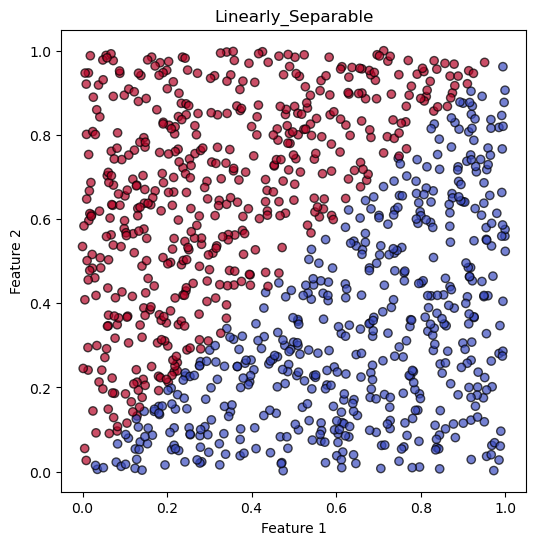

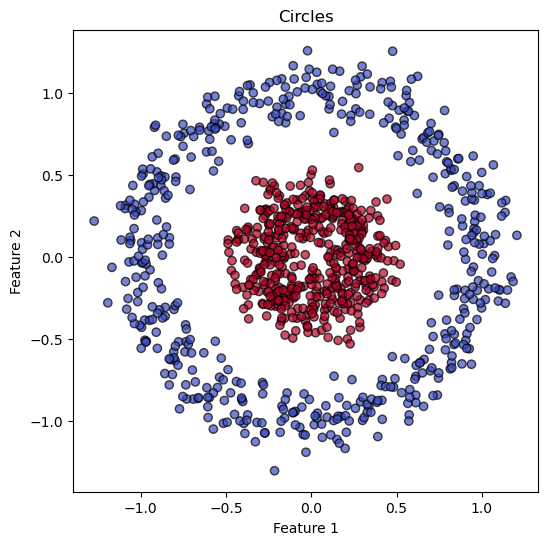

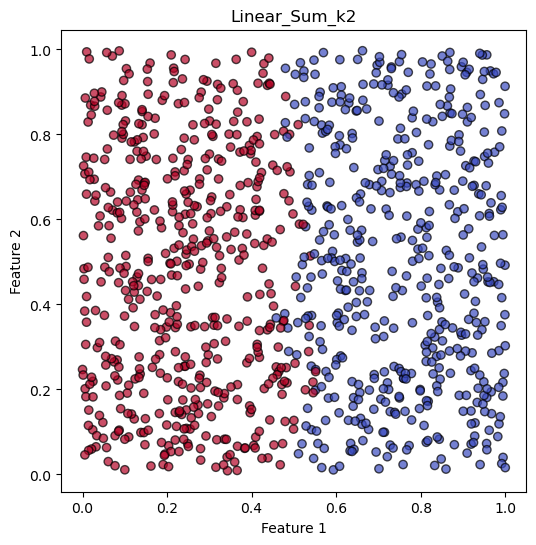

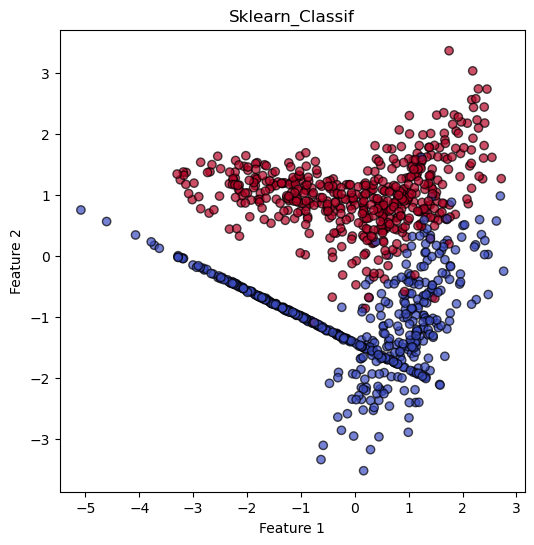

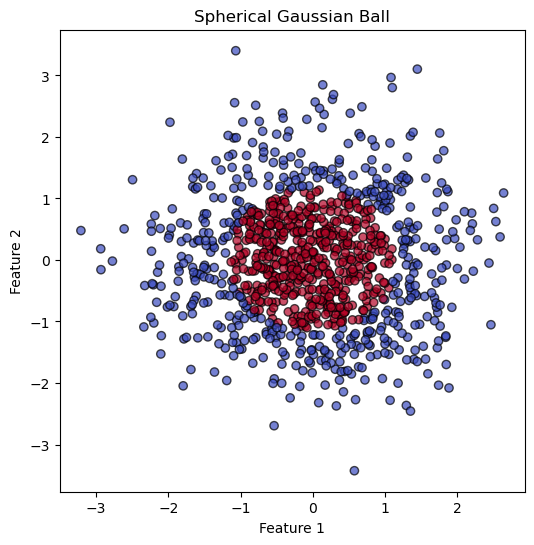

In [8]:
# Function to plot a dataset
def plot_dataset(X, y, title=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    if title:
        plt.title(title)
    plt.show()

# Loop over datasets
for name, gen in DATASETS:
    X, y = gen()
    plot_dataset(X, y, title=name)

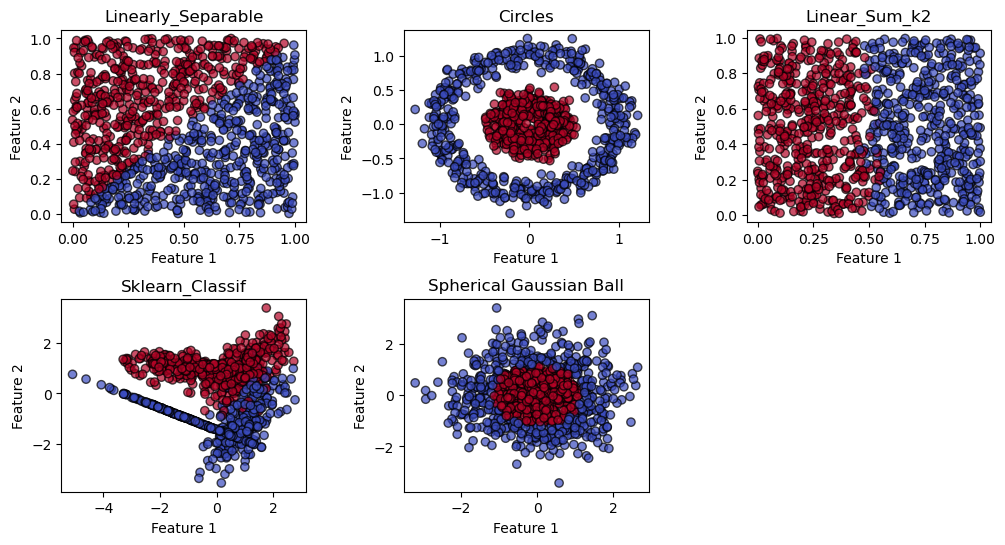

In [9]:
# Function to plot datasets
def plot_dataset(X, y, ax, title=None):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    if title:
        ax.set_title(title)

num_datasets = len(DATASETS)
ncols = 3  
nrows = (num_datasets + ncols - 1) // ncols  


fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
axes = axes.flatten()

for i, (name, gen) in enumerate(DATASETS):
    X, y = gen()
    plot_dataset(X, y, axes[i], title=name)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

if num_datasets < ncols * nrows:
    for j in range(num_datasets, ncols * (nrows - 1)):
        axes[j].axis('off')

plt.tight_layout()
plt.show()


In [10]:
def dataset_geometry_metrics(X, y, k=5):
    # Class balance
    class_probs = np.bincount(y) / len(y)
    class_entropy = entropy(class_probs)

    # Linear separability (geometry proxy)
    clf = LogisticRegression().fit(X, y)
    linear_error = 1 - accuracy_score(y, clf.predict(X))

    # kNN-based geometry
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    dists, idxs = nn.kneighbors(X)
    neighbor_labels = y[idxs[:, 1:]]

    # Local instability
    knn_disagreement = np.mean(neighbor_labels != y[:, None])

    # Noise / ambiguity proxy
    knn_entropy = np.mean([
        entropy(np.bincount(row, minlength=2) / k)
        for row in neighbor_labels
    ])

    # Density heterogeneity
    mean_nn_dist = dists[:, 1:].mean(axis=1)
    density_cv = np.std(mean_nn_dist) / np.mean(mean_nn_dist)

    # Feature dominance (sparsity)
    corrs = [abs(np.corrcoef(X[:, i], y)[0, 1]) for i in range(X.shape[1])]
    feature_gini = np.sum(np.abs(np.subtract.outer(corrs, corrs))) / (
        2 * len(corrs) * np.sum(corrs)
    )

    return {
        "class_entropy": class_entropy,
        "linear_error": linear_error,
        "knn_disagreement": knn_disagreement,
        "knn_entropy": knn_entropy,
        "density_cv": density_cv,
        "feature_gini": feature_gini,
    }


| Metric | Meaning (Dataset Property) | Interpretation for XAI Stability |
|------|----------------------------|----------------------------------|
| class_entropy | Entropy of the class distribution | Measures class balance. Higher values indicate balanced classes. Extreme imbalance can bias local explanations and affect baseline comparisons, but this metric mainly controls for dataset bias rather than geometry. |
| linear_error | Error of a linear classifier on the dataset | Proxy for boundary non-linearity. Low values indicate a mostly linear decision boundary, where explanations tend to be more stable and consistent. High values indicate complex or curved boundaries, which increase explanation variability. |
| knn_disagreement | Fraction of nearest neighbors with a different label | Measures local class ambiguity. High values indicate that small input perturbations may flip the label, which strongly destabilizes local explanations. |
| knn_entropy | Entropy of labels in local neighborhoods | Measures local label uncertainty. Higher values indicate noisy or overlapping regions, where explanations become less reliable and less similar across runs. |
| density_cv | Coefficient of variation of kNN distances | Measures density heterogeneity. High values indicate uneven sampling density, which affects perturbation-based explanations by making neighborhood selection unstable. |
| feature_gini | Gini coefficient of feature–label correlations | Measures feature dominance (sparsity). High values indicate that one feature dominates the decision, leading to more focused and stable explanations. Low values indicate distributed influence, increasing explanation variability. |

In [11]:
rows = []

for dataset_name, dataset_fn in DATASETS:
    X, y = dataset_fn()
    metrics = dataset_geometry_metrics(X, y)
    metrics["dataset"] = dataset_name
    rows.append(metrics)

dataset_metrics_df = pd.DataFrame(rows)
display(dataset_metrics_df)

class_entropy  linear_error  knn_disagreement  knn_entropy  density_cv  \
0       0.693115         0.012            0.0316     0.051009    0.273410   
1       0.693147         0.487            0.0002     0.000500    0.517756   
2       0.692905         0.021            0.0332     0.044590    0.273569   
3       0.693139         0.063            0.0474     0.061396    0.830982   
4       0.693147         0.475            0.0402     0.062346    0.757523   

   feature_gini                  dataset  
0      0.006207       Linearly_Separable  
1      0.113756                  Circles  
2      0.453914            Linear_Sum_k2  
3      0.471334          Sklearn_Classif  
4      0.083773  Spherical Gaussian Ball

- **Linearly_Separable**: The dataset has an almost perfectly linear decision boundary, low local label ambiguity, and uniform density, which, a priori, makes explanations highly stable and consistent across methods and runs.

- **Circles**: The decision boundary is strongly non-linear but locally clean, a priori leading to stable local explanations that vary substantially across the input space and challenge linear surrogate-based XAI methods.

- **Linear_Sum_k2**: The dataset is linearly separable with strong feature dominance, resulting in sparse, focused, and (a priori) highly robust explanations with minimal variability.

- **Sklearn_Classif**: Moderate non-linearity combined with high density heterogeneity, a priori, causes explanation stability to vary across regions, particularly affecting perturbation-based methods.

- **Spherical Gaussian Ball**: The highly non-linear radial boundary, uneven density, and distributed feature influence make this dataset prone to explanation instability, especially near the decision boundary.

In [12]:
# Compute explanations (KernelSHAP & LIME) for selected instances, perturbations and neighbours
    # Comment this cell if necessary
explanations = {}  # structure: dataset -> method -> {'ref':array, 'pert': list of arrays, 'nn': list of arrays, 'proba_ref':...}

for name, ds in data_store.items():
    print("Computing explanations for dataset:", name)
    model = models_store[name]
    X_train = ds['X_train']
    X_test = ds['X_test']
    y_test = ds['y_test']

    # prepare background for KernelSHAP
    if FIX_SHAP_BACKGROUND:
        rng = np.random.RandomState(GLOBAL_SEED)
        bg_idx = rng.choice(np.arange(X_train.shape[0]), size=min(BACKGROUND_SAMPLE_FOR_SHAP, X_train.shape[0]), replace=False)
        X_background = X_train[bg_idx]
    else:
        X_background = X_train[np.random.choice(X_train.shape[0], size=min(BACKGROUND_SAMPLE_FOR_SHAP, X_train.shape[0]), replace=False)]

    shap_explainer = make_shap_explainer_for_model(model, X_background)

    # LIME explainer uses X_train as background for its internal sampling
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=[f"f{i}" for i in range(X_train.shape[1])],
        class_names=[str(c) for c in np.unique(y_test)],
        discretize_continuous=True,
        random_state=GLOBAL_SEED
    )

    store = {'kernel': {'ref':[], 'pert':[], 'nn':[], 'proba_ref':[]},
             'lime': {'ref':[], 'pert':[], 'nn':[], 'proba_ref':[]}}

    sel = precomp_store[name]
    X_sel = sel['X_sel']
    perturbations = sel['perturbations']
    neighbor_idxs = sel['neighbor_idxs']

    # precompute prediction probabilities for ref points and the test set
    proba_test = model.predict_proba(X_test)[:, 1]

    # For speed: compute shap for the reference points and all perturbations flattened where possible
    # Flatten perturbations for batch SHAP
    all_pert_flat = np.vstack(perturbations)  # (n_sel * M, d)
    # shap for reference points
    try:
        shap_ref = compute_kernelshap_for_batch(shap_explainer, X_sel, nsamples=KERNELSHAP_SAMPLES)
    except Exception as e:
        # fallback to per-instance
        shap_ref = []
        for x in X_sel:
            shap_ref.append(compute_kernelshap_for_batch(shap_explainer, x.reshape(1,-1), nsamples=KERNELSHAP_SAMPLES)[0])
        shap_ref = np.vstack(shap_ref)
    # shap for all perturbations batch
    try:
        shap_pert_all = compute_kernelshap_for_batch(shap_explainer, all_pert_flat, nsamples=KERNELSHAP_SAMPLES)
    except Exception as e:
        shap_pert_all = []
        for xp in all_pert_flat:
            shap_pert_all.append(compute_kernelshap_for_batch(shap_explainer, xp.reshape(1,-1), nsamples=KERNELSHAP_SAMPLES)[0])
        shap_pert_all = np.vstack(shap_pert_all)

    # slice pert per selected instance
    n_sel = X_sel.shape[0]
    for i in range(n_sel):
        store['kernel']['ref'].append(shap_ref[i])
        store['kernel']['proba_ref'].append(proba_test[sel['sel_idx'][i]])
        # perturbations block
        block = shap_pert_all[i*M_PERTURB:(i+1)*M_PERTURB]
        store['kernel']['pert'].append(block)
        # nearest neighbours explanations: compute SHAP for neighbor points (batch)
        nn_idxs = neighbor_idxs[i]
        if len(nn_idxs) > 0:
            X_nn = X_test[nn_idxs]
            try:
                shap_nn = compute_kernelshap_for_batch(shap_explainer, X_nn, nsamples=KERNELSHAP_SAMPLES)
            except Exception:
                shap_nn = np.vstack([compute_kernelshap_for_batch(shap_explainer, x.reshape(1,-1), nsamples=KERNELSHAP_SAMPLES)[0] for x in X_nn])
            store['kernel']['nn'].append(shap_nn)
        else:
            store['kernel']['nn'].append(np.empty((0, X_train.shape[1])))

    # LIME: compute explanations (reference, pert, nn) — slower; do per instance
    for i in range(n_sel):
        x = X_sel[i]
        # reference
        exp_ref = lime_explainer.explain_instance(x, model.predict_proba, num_features=X_train.shape[1], num_samples=LIME_SAMPLES)
        if 1 in exp_ref.local_exp:
            d = dict(exp_ref.local_exp[1])
        else:
            d = dict(exp_ref.local_exp[next(iter(exp_ref.local_exp))])
        v = np.zeros(X_train.shape[1])
        for k,vv in d.items():
            v[k] = vv
        store['lime']['ref'].append(v)
        store['lime']['proba_ref'].append(proba_test[sel['sel_idx'][i]])

        # perturbations
        Xp = perturbations[i]
        pert_vecs = []
        for xp in Xp:
            exp = lime_explainer.explain_instance(xp, model.predict_proba, num_features=X_train.shape[1], num_samples=LIME_SAMPLES)
            if 1 in exp.local_exp:
                d = dict(exp.local_exp[1])
            else:
                d = dict(exp.local_exp[next(iter(exp.local_exp))])
            vec = np.zeros(X_train.shape[1])
            for k,vv in d.items():
                vec[k] = vv
            pert_vecs.append(vec)
        store['lime']['pert'].append(np.vstack(pert_vecs))

        # nearest neighbours
        nn_idxs = neighbor_idxs[i]
        if len(nn_idxs) > 0:
            X_nn = X_test[nn_idxs]
            nn_vecs = []
            for xn in X_nn:
                exp = lime_explainer.explain_instance(xn, model.predict_proba, num_features=X_train.shape[1], num_samples=LIME_SAMPLES)
                if 1 in exp.local_exp:
                    d = dict(exp.local_exp[1])
                else:
                    d = dict(exp.local_exp[next(iter(exp.local_exp))])
                vec = np.zeros(X_train.shape[1])
                for k,vv in d.items():
                    vec[k] = vv
                nn_vecs.append(vec)
            store['lime']['nn'].append(np.vstack(nn_vecs))
        else:
            store['lime']['nn'].append(np.empty((0, X_train.shape[1])))

    explanations[name] = store
    print("  done:", name)

Computing explanations for dataset: Linearly_Separable


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  done: Linearly_Separable
Computing explanations for dataset: Circles


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  done: Circles
Computing explanations for dataset: Linear_Sum_k2


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  done: Linear_Sum_k2
Computing explanations for dataset: Sklearn_Classif


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  done: Sklearn_Classif
Computing explanations for dataset: Spherical Gaussian Ball


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  done: Spherical Gaussian Ball


In [13]:
# Comment this cell if necessary
SAVE_DIR = "cached_explanations"
os.makedirs(SAVE_DIR, exist_ok=True)

save_path = os.path.join(SAVE_DIR, "explanations.joblib")

joblib.dump(
    {
        "explanations": explanations,
        "GLOBAL_SEED": GLOBAL_SEED,
        "KERNELSHAP_SAMPLES": KERNELSHAP_SAMPLES,
        "LIME_SAMPLES": LIME_SAMPLES,
        "M_PERTURB": M_PERTURB,
        "BACKGROUND_SAMPLE_FOR_SHAP": BACKGROUND_SAMPLE_FOR_SHAP
    },
    save_path,
    compress=3  # good tradeoff between speed & size
)

print(f"Explanations saved to: {save_path}")

Explanations saved to: cached_explanations/explanations.joblib


Upon initial execution of the code, users are encouraged to comment the two cells above (the ones that generate explanations and save them) to prevent the code from executing again, which can be time-consuming.

In [14]:
load_path = "cached_explanations/explanations.joblib"

cache = joblib.load(load_path)

explanations = cache["explanations"]

print("Loaded explanations for datasets:", list(explanations.keys()))

Loaded explanations for datasets: ['Linearly_Separable', 'Circles', 'Linear_Sum_k2', 'Sklearn_Classif', 'Spherical Gaussian Ball']


In [15]:
# Per-instance variability metrics (perturbation-based and NN-based)
results_instances = []  
for name, store in explanations.items():
    sel = precomp_store[name]
    proba_refs = store['kernel']['proba_ref']  # same for both methods
    n_sel = len(store['kernel']['ref'])
    for i in range(n_sel):
        proba = proba_refs[i]
        margin = abs(proba - 0.5)
        # for each method and each scenario
        for method in ['kernel', 'lime']:
            # reference + perturbations
            ref_vec = store[method]['ref'][i]
            pert_set = store[method]['pert'][i]  # shape (M, p)
            runs_raw = np.vstack([ref_vec, pert_set])
            runs_norm = np.vstack([l2_normalize(r) for r in runs_raw])
            metrics_pert = compute_variability_metrics(runs_raw, runs_norm)
            metrics_pert.update({'dataset': name, 'method': method, 'instance_idx': i, 'scenario': 'perturbation', 'margin': margin, 'proba': proba})
            results_instances.append(metrics_pert)

            # reference + nearest neighbors
            nn_set = store[method]['nn'][i]  # shape (k, p)
            if nn_set.shape[0] == 0:
                continue
            runs_raw_nn = np.vstack([ref_vec, nn_set])
            runs_norm_nn = np.vstack([l2_normalize(r) for r in runs_raw_nn])
            metrics_nn = compute_variability_metrics(runs_raw_nn, runs_norm_nn)
            metrics_nn.update({'dataset': name, 'method': method, 'instance_idx': i, 'scenario': 'neighbour', 'margin': margin, 'proba': proba})
            results_instances.append(metrics_nn)

results_df_instances = pd.DataFrame(results_instances)
results_df_instances.head()


mean_pairwise_similarity  mean_pairwise_distance  std_pairwise_distance  \
0                  0.985207                0.015162               0.012367   
1                  0.953756                0.048486                    NaN   
2                  0.977507                0.023235               0.015334   
3                  0.952031                0.050386                    NaN   
4                  0.995782                0.004244               0.002856   

   mean_feature_variance  sign_flip_rate   icc_1_1  kendalls_w   norm_cv  \
0               0.000380             0.0  0.997978         1.0  0.007515   
1               0.002351             0.0  0.986212         1.0  0.024828   
2               0.000771             0.0  0.811206         1.0  0.028745   
3               0.002539             0.0  0.551087         1.0  0.021656   
4               0.000026             0.0  0.999915         1.0  0.006821   

   mean_feature_cv  mean_norm             dataset  method  instance_idx  \
0         0.045381   0.448165  Linearly_Separable  kernel             0   
1         0.104100   0.442248  Linearly_Separable  kernel             0   
2         0.048682   0.292192  Linearly_Separable    lime             0   
3         0.071948   0.291921  Linearly_Separable    lime             0   
4         0.022826   0.350519  Linearly_Separable  kernel             1   

       scenario  margin  proba  
0  perturbation   0.485  0.985  
1     neighbour   0.485  0.985  
2  perturbation   0.485  0.985  
3     neighbour   0.485  0.985  
4  perturbation   0.495  0.005

In [16]:
results_df_instances

mean_pairwise_similarity  mean_pairwise_distance  std_pairwise_distance  \
0                     0.985207                0.015162               0.012367   
1                     0.953756                0.048486                    NaN   
2                     0.977507                0.023235               0.015334   
3                     0.952031                0.050386                    NaN   
4                     0.995782                0.004244               0.002856   
...                        ...                     ...                    ...   
3995                  0.995985                0.004031                    NaN   
3996                  0.993594                0.006474               0.005254   
3997                  0.996700                0.003311                    NaN   
3998                  0.985814                0.014480               0.009661   
3999                  0.990061                0.010038                    NaN   

      mean_feature_variance  sign_flip_rate   icc_1_1  kendalls_w   norm_cv  \
0                  0.000380             0.0  0.997978         1.0  0.007515   
1                  0.002351             0.0  0.986212         1.0  0.024828   
2                  0.000771             0.0  0.811206         1.0  0.028745   
3                  0.002539             0.0  0.551087         1.0  0.021656   
4                  0.000026             0.0  0.999915         1.0  0.006821   
...                     ...             ...       ...         ...       ...   
3995               0.000016             0.0  0.780340         1.0  0.020570   
3996               0.000069             0.0  0.999907         1.0  0.004926   
3997               0.000011             0.0  0.999985         1.0  0.008861   
3998               0.000301             0.0  0.999698         1.0  0.024165   
3999               0.000101             0.0  0.999899         1.0  0.011423   

      mean_feature_cv  mean_norm                  dataset  method  \
0            0.045381   0.448165       Linearly_Separable  kernel   
1            0.104100   0.442248       Linearly_Separable  kernel   
2            0.048682   0.292192       Linearly_Separable    lime   
3            0.071948   0.291921       Linearly_Separable    lime   
4            0.022826   0.350519       Linearly_Separable  kernel   
...               ...        ...                      ...     ...   
3995         0.020662   0.415682  Spherical Gaussian Ball    lime   
3996         0.024599   0.574440  Spherical Gaussian Ball  kernel   
3997         0.010391   0.579251  Spherical Gaussian Ball  kernel   
3998         0.033694   0.437776  Spherical Gaussian Ball    lime   
3999         0.014233   0.435871  Spherical Gaussian Ball    lime   

      instance_idx      scenario  margin  proba  
0                0  perturbation   0.485  0.985  
1                0     neighbour   0.485  0.985  
2                0  perturbation   0.485  0.985  
3                0     neighbour   0.485  0.985  
4                1  perturbation   0.495  0.005  
...            ...           ...     ...    ...  
3995           198     neighbour   0.455  0.045  
3996           199  perturbation   0.485  0.015  
3997           199     neighbour   0.485  0.015  
3998           199  perturbation   0.485  0.015  
3999           199     neighbour   0.485  0.015  

[4000 rows x 16 columns]

In [17]:
# Are explanations similar for similar inputs? (summary & boxplots)

# Summary table (dataset x method x scenario)
rq1_summary = (
    results_df_instances
    .groupby(['dataset','method','scenario'])['mean_pairwise_similarity']
    .agg(['mean','std','count'])
    .reset_index()
    .rename(columns={'mean':'mean_similarity','std':'std_similarity','count':'n'})
)
display(rq1_summary)

dataset  method      scenario  mean_similarity  \
0                   Circles  kernel     neighbour         0.977391   
1                   Circles  kernel  perturbation         0.992554   
2                   Circles    lime     neighbour         0.943595   
3                   Circles    lime  perturbation         0.972742   
4             Linear_Sum_k2  kernel     neighbour         0.978165   
5             Linear_Sum_k2  kernel  perturbation         0.988494   
6             Linear_Sum_k2    lime     neighbour         0.984514   
7             Linear_Sum_k2    lime  perturbation         0.988251   
8        Linearly_Separable  kernel     neighbour         0.950304   
9        Linearly_Separable  kernel  perturbation         0.979943   
10       Linearly_Separable    lime     neighbour         0.954442   
11       Linearly_Separable    lime  perturbation         0.977228   
12          Sklearn_Classif  kernel     neighbour         0.967229   
13          Sklearn_Classif  kernel  perturbation         0.984564   
14          Sklearn_Classif    lime     neighbour         0.976794   
15          Sklearn_Classif    lime  perturbation         0.986457   
16  Spherical Gaussian Ball  kernel     neighbour         0.929941   
17  Spherical Gaussian Ball  kernel  perturbation         0.978222   
18  Spherical Gaussian Ball    lime     neighbour         0.952848   
19  Spherical Gaussian Ball    lime  perturbation         0.976037   

    std_similarity    n  
0         0.043661  200  
1         0.011238  200  
2         0.122539  200  
3         0.042070  200  
4         0.067952  200  
5         0.024697  200  
6         0.049457  200  
7         0.016544  200  
8         0.071209  200  
9         0.027316  200  
10        0.089116  200  
11        0.028557  200  
12        0.066190  200  
13        0.026537  200  
14        0.054608  200  
15        0.011164  200  
16        0.118422  200  
17        0.038186  200  
18        0.106711  200  
19        0.033348  200

In [18]:
rq1_summary["mean_similarity"].describe()

count    20.000000
mean      0.971986
std       0.016956
min       0.929941
25%       0.964033
50%       0.977310
75%       0.984526
max       0.992554
Name: mean_similarity, dtype: float64

In [19]:
dist_records = []

for name, store in explanations.items():
    sel = precomp_store[name]
    X_sel = sel['X_sel']

    for i, x_ref in enumerate(X_sel):
        for method in ['kernel', 'lime']:

            # --- Perturbation scenario ---
            pert_set = store[method]['pert'][i]
            expl_ref = store[method]['ref'][i]

            for j, xp in enumerate(pert_set):
                # Input-space distance
                d_in = np.linalg.norm(x_ref - xp)

                # Explanation-space distance (L2)
                d_expl = np.linalg.norm(expl_ref - xp)

                dist_records.append({
                    'dataset': name,
                    'method': method,
                    'scenario': 'perturbation',
                    'instance_idx': i,
                    'pert_idx': j,
                    'input_distance': d_in,
                    'expl_distance': d_expl
                })

            # --- Neighbour scenario ---
            nn_set = store[method]['nn'][i]

            for j, xn in enumerate(nn_set):
                # Input-space distance
                d_in = np.linalg.norm(x_ref - xn)

                # Explanation-space distance (L2)
                d_expl = np.linalg.norm(expl_ref - xn)

                dist_records.append({
                    'dataset': name,
                    'method': method,
                    'scenario': 'neighbour',
                    'instance_idx': i,
                    'nn_idx': j,
                    'input_distance': d_in,
                    'expl_distance': d_expl
                })

# Create DataFrame
dist_df = pd.DataFrame(dist_records)

RQ1.1 Hypothesis test
----------------------
H0: slope ≤ 0  (explanation distance does NOT increase with input distance)
H1: slope > 0  (explanation distance increases with input distance)
Significance level α = 0.05



dataset  method      scenario     slope         r  \
0                   Circles  kernel     neighbour  0.020705  0.200234   
1                   Circles    lime     neighbour  0.046871  0.088660   
2                   Circles  kernel  perturbation  0.000840  0.028074   
3                   Circles    lime  perturbation -0.005489 -0.021639   
4             Linear_Sum_k2  kernel     neighbour -0.010969 -0.054988   
5             Linear_Sum_k2    lime     neighbour -0.009477 -0.035528   
6             Linear_Sum_k2  kernel  perturbation -0.000778 -0.011236   
7             Linear_Sum_k2    lime  perturbation  0.003171  0.025979   
8        Linearly_Separable  kernel     neighbour -0.021864 -0.122970   
9        Linearly_Separable    lime     neighbour -0.021361 -0.072870   
10       Linearly_Separable  kernel  perturbation -0.005584 -0.083453   
11       Linearly_Separable    lime  perturbation -0.007160 -0.050886   
12          Sklearn_Classif  kernel     neighbour -0.002377 -0.022170   
13          Sklearn_Classif    lime     neighbour -0.008365 -0.058488   
14          Sklearn_Classif  kernel  perturbation -0.004928 -0.089960   
15          Sklearn_Classif    lime  perturbation  0.001824  0.042267   
16  Spherical Gaussian Ball  kernel     neighbour  0.022242  0.105897   
17  Spherical Gaussian Ball    lime     neighbour  0.012034  0.046110   
18  Spherical Gaussian Ball  kernel  perturbation -0.000558 -0.009494   
19  Spherical Gaussian Ball    lime  perturbation -0.005766 -0.055336   

    p_one_sided  significant_α=0.05  supports_RQ1.1  n_pairs  
0      0.002236                True            True      200  
1      0.105936               False           False      200  
2      0.104747               False           False     2000  
3      0.833281               False           False     2000  
4      0.780347               False           False      200  
5      0.691270               False           False      200  
6      0.692233               False           False     2000  
7      0.122761               False           False     2000  
8      0.958607               False           False      200  
9      0.847423               False           False      200  
10     0.999907               False           False     2000  
11     0.988570               False           False     2000  
12     0.622330               False           False      200  
13     0.794651               False           False      200  
14     0.999972               False           False     2000  
15     0.029385                True            True     2000  
16     0.067795               False           False      200  
17     0.258380               False           False      200  
18     0.664335               False           False     2000  
19     0.993339               False           False     2000

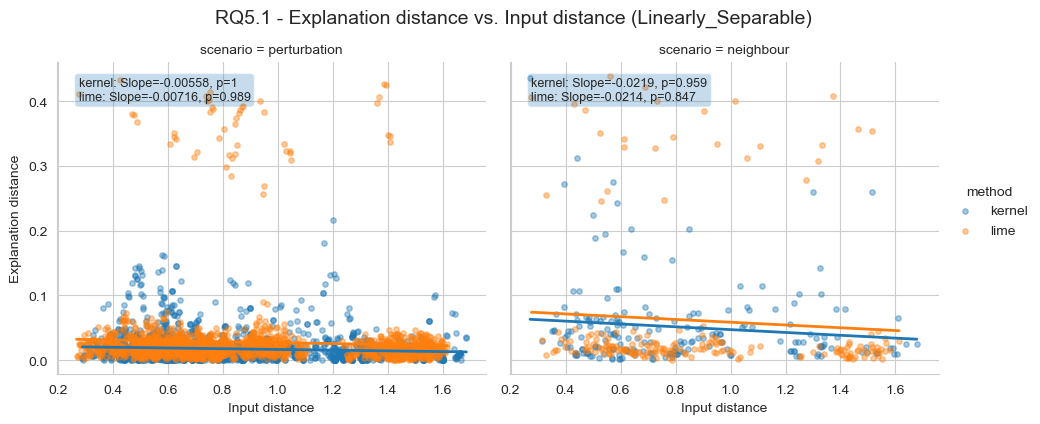

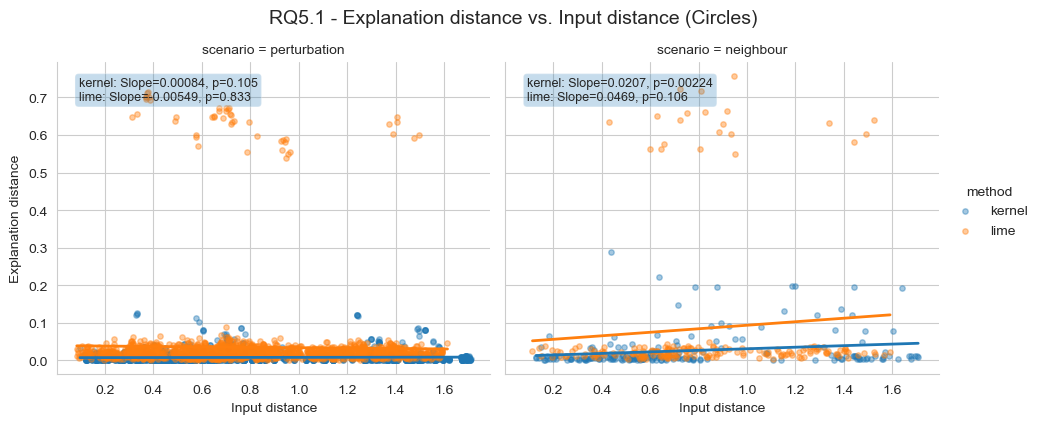

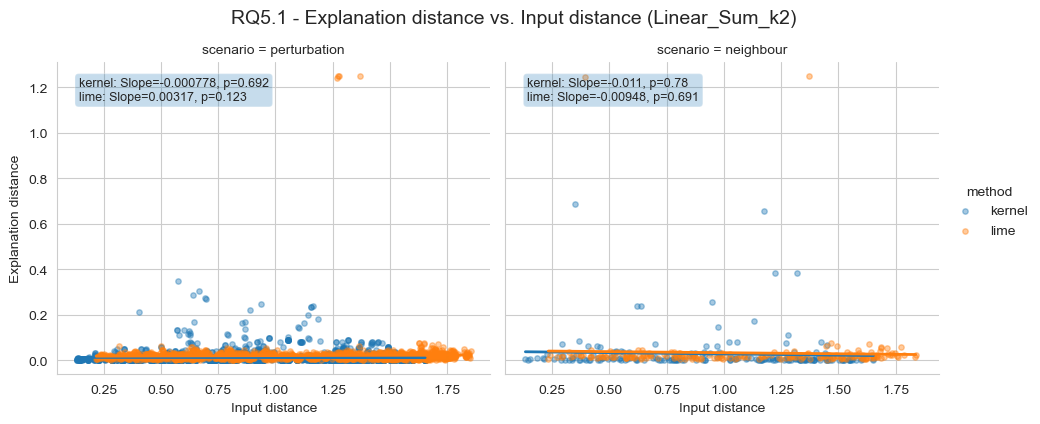

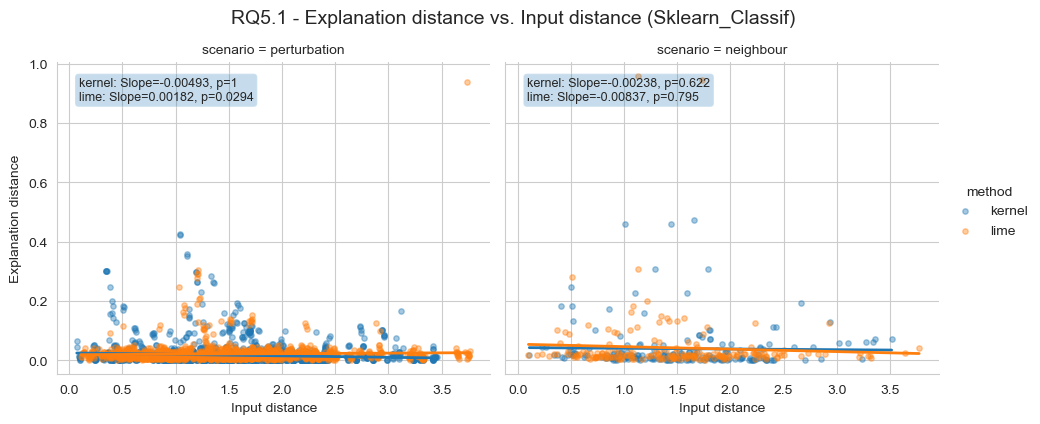

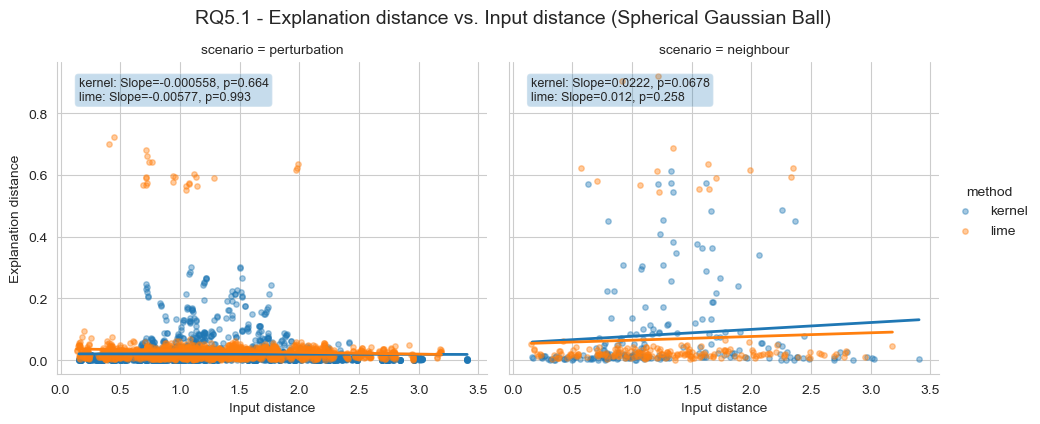

In [20]:
# Explanation distance vs input distance
# ONE-SIDED pooled regression + plots

ALPHA = 0.05

# Hypotheses (printed for transparency)
print("RQ1.1 Hypothesis test")
print("----------------------")
print("H0: slope ≤ 0  (explanation distance does NOT increase with input distance)")
print("H1: slope > 0  (explanation distance increases with input distance)")
print(f"Significance level α = {ALPHA}\n")

# Pooled one-sided regression analysis
rq11_rows = []

for (ds, scenario, method), grp in dist_df.groupby(
    ['dataset', 'scenario', 'method']
):
    if len(grp) < 3:
        continue

    res = linregress(grp['input_distance'], grp['expl_distance'])

    slope = res.slope
    r = res.rvalue
    p_two_sided = res.pvalue

    # One-sided p-value for H1: slope > 0
    if slope > 0:
        p_one_sided = p_two_sided / 2
    else:
        p_one_sided = 1 - (p_two_sided / 2)

    rq11_rows.append({
        "dataset": ds,
        "method": method,
        "scenario": scenario,
        "slope": slope,                 # effect size
        "r": r,
        "p_one_sided": p_one_sided,     # evidence
        "significant_α=0.05": p_one_sided < ALPHA,
        "supports_RQ1.1": (slope > 0) and (p_one_sided < ALPHA),
        "n_pairs": len(grp)
    })

rq11_df = (
    pd.DataFrame(rq11_rows)
    .sort_values(["dataset", "scenario", "method"])
    .reset_index(drop=True)
)

display(rq11_df)

# Plots: explanation distance vs input distance
sns.set_style("whitegrid")

for ds in dist_df['dataset'].unique():

    sub = dist_df[dist_df['dataset'] == ds]

    g = sns.lmplot(
        data=sub,
        x="input_distance",
        y="expl_distance",
        hue="method",
        col="scenario",
        scatter_kws={"s": 15, "alpha": 0.4},
        line_kws={"linewidth": 2},
        height=4,
        aspect=1.2,
        ci=None
    )

    # Annotate pooled slopes + one-sided p-values
    for ax, scenario in zip(g.axes.flat, g.col_names):

        annot_rows = rq11_df[
            (rq11_df["dataset"] == ds) &
            (rq11_df["scenario"] == scenario)
        ]

        text = "\n".join(
            [
                f"{row.method}: Slope={row.slope:.3g}, p={row.p_one_sided:.3g}"
                for _, row in annot_rows.iterrows()
            ]
        )

        ax.text(
            0.05, 0.95,
            text,
            transform=ax.transAxes,
            ha="left",
            va="top",
            fontsize=9,
            bbox=dict(boxstyle="round", alpha=0.25)
        )

        ax.set_xlabel("Input distance")
        ax.set_ylabel("Explanation distance")

    plt.suptitle(
        f"RQ5.1 - Explanation distance vs. Input distance ({ds})",
        y=1.05,
        fontsize=14
    )
    plt.show()

In [21]:
# Two-sided and negative slope testing
# ONE-SIDED negative slope + TWO-SIDED regression

ALPHA = 0.05

print("RQ5.1 Negative slope / two-sided test")
print("-------------------------------------")
print(f"Significance level α = {ALPHA}\n")

rq11_neg_rows = []

for (ds, scenario, method), grp in dist_df.groupby(
    ['dataset', 'scenario', 'method']
):
    if len(grp) < 3:
        continue

    res = linregress(grp['input_distance'], grp['expl_distance'])

    slope = res.slope
    r = res.rvalue
    p_two_sided = res.pvalue

    # One-sided test for slope < 0
    if slope < 0:
        p_one_sided_neg = p_two_sided / 2
    else:
        p_one_sided_neg = 1 - (p_two_sided / 2)

    rq11_neg_rows.append({
        "dataset": ds,
        "method": method,
        "scenario": scenario,
        "slope": slope,
        "r": r,
        "p_one_sided_neg": p_one_sided_neg,   # evidence for negative slope
        "significant_neg_α=0.05": p_one_sided_neg < ALPHA,
        "n_pairs": len(grp)
    })

rq11_neg_df = (
    pd.DataFrame(rq11_neg_rows)
    .sort_values(["dataset", "scenario", "method"])
    .reset_index(drop=True)
)

display(rq11_neg_df)

RQ5.1 Negative slope / two-sided test
-------------------------------------
Significance level α = 0.05



dataset  method      scenario     slope         r  \
0                   Circles  kernel     neighbour  0.020705  0.200234   
1                   Circles    lime     neighbour  0.046871  0.088660   
2                   Circles  kernel  perturbation  0.000840  0.028074   
3                   Circles    lime  perturbation -0.005489 -0.021639   
4             Linear_Sum_k2  kernel     neighbour -0.010969 -0.054988   
5             Linear_Sum_k2    lime     neighbour -0.009477 -0.035528   
6             Linear_Sum_k2  kernel  perturbation -0.000778 -0.011236   
7             Linear_Sum_k2    lime  perturbation  0.003171  0.025979   
8        Linearly_Separable  kernel     neighbour -0.021864 -0.122970   
9        Linearly_Separable    lime     neighbour -0.021361 -0.072870   
10       Linearly_Separable  kernel  perturbation -0.005584 -0.083453   
11       Linearly_Separable    lime  perturbation -0.007160 -0.050886   
12          Sklearn_Classif  kernel     neighbour -0.002377 -0.022170   
13          Sklearn_Classif    lime     neighbour -0.008365 -0.058488   
14          Sklearn_Classif  kernel  perturbation -0.004928 -0.089960   
15          Sklearn_Classif    lime  perturbation  0.001824  0.042267   
16  Spherical Gaussian Ball  kernel     neighbour  0.022242  0.105897   
17  Spherical Gaussian Ball    lime     neighbour  0.012034  0.046110   
18  Spherical Gaussian Ball  kernel  perturbation -0.000558 -0.009494   
19  Spherical Gaussian Ball    lime  perturbation -0.005766 -0.055336   

    p_one_sided_neg  significant_neg_α=0.05  n_pairs  
0          0.997764                   False      200  
1          0.894064                   False      200  
2          0.895253                   False     2000  
3          0.166719                   False     2000  
4          0.219653                   False      200  
5          0.308730                   False      200  
6          0.307767                   False     2000  
7          0.877239                   False     2000  
8          0.041393                    True      200  
9          0.152577                   False      200  
10         0.000093                    True     2000  
11         0.011430                    True     2000  
12         0.377670                   False      200  
13         0.205349                   False      200  
14         0.000028                    True     2000  
15         0.970615                   False     2000  
16         0.932205                   False      200  
17         0.741620                   False      200  
18         0.335665                   False     2000  
19         0.006661                    True     2000

In [22]:
rq11_neg_df[rq11_neg_df["significant_neg_α=0.05"] == True]

dataset  method      scenario     slope         r  \
8        Linearly_Separable  kernel     neighbour -0.021864 -0.122970   
10       Linearly_Separable  kernel  perturbation -0.005584 -0.083453   
11       Linearly_Separable    lime  perturbation -0.007160 -0.050886   
14          Sklearn_Classif  kernel  perturbation -0.004928 -0.089960   
19  Spherical Gaussian Ball    lime  perturbation -0.005766 -0.055336   

    p_one_sided_neg  significant_neg_α=0.05  n_pairs  
8          0.041393                    True      200  
10         0.000093                    True     2000  
11         0.011430                    True     2000  
14         0.000028                    True     2000  
19         0.006661                    True     2000

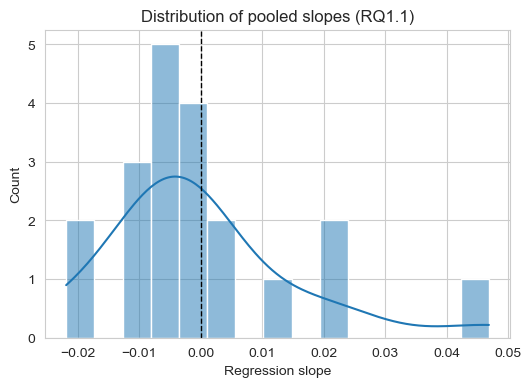

In [23]:
# Diagnostic: distribution of pooled slopes
plt.figure(figsize=(6,4))
sns.histplot(rq11_df['slope'], bins=15, kde=True)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Regression slope")
plt.ylabel("Count")
plt.title("Distribution of pooled slopes (RQ1.1)")
plt.show()

Dataset      Scenario  n_pairs  kernel_mean  lime_mean  \
3                  Circles     neighbour      200     0.977391   0.943595   
2                  Circles  perturbation      200     0.992554   0.972742   
5            Linear_Sum_k2     neighbour      200     0.978165   0.984514   
4            Linear_Sum_k2  perturbation      200     0.988494   0.988251   
1       Linearly_Separable     neighbour      200     0.950304   0.954442   
0       Linearly_Separable  perturbation      200     0.979943   0.977228   
7          Sklearn_Classif     neighbour      200     0.967229   0.976794   
6          Sklearn_Classif  perturbation      200     0.984564   0.986457   
9  Spherical Gaussian Ball     neighbour      200     0.929941   0.952848   
8  Spherical Gaussian Ball  perturbation      200     0.978222   0.976037   

   mean_diff  wilcoxon_stat  p_value  
3   0.033796         6918.0   0.0001  
2   0.019812         2005.0   0.0000  
5  -0.006349         8065.0   0.0154  
4   0.000243         6547.0   0.0000  
1  -0.004138         6993.0   0.0002  
0   0.002715         8309.0   0.0336  
7  -0.009564         8755.0   0.1141  
6  -0.001894         7839.0   0.0070  
9  -0.022907         9340.0   0.3863  
8   0.002185         6999.0   0.0002

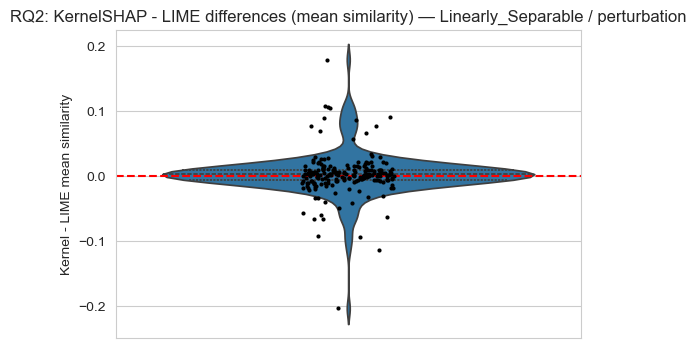

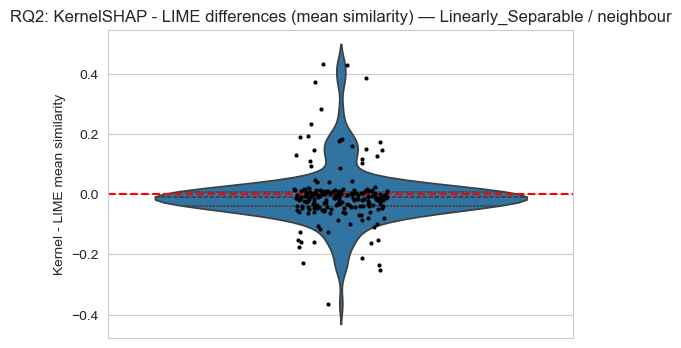

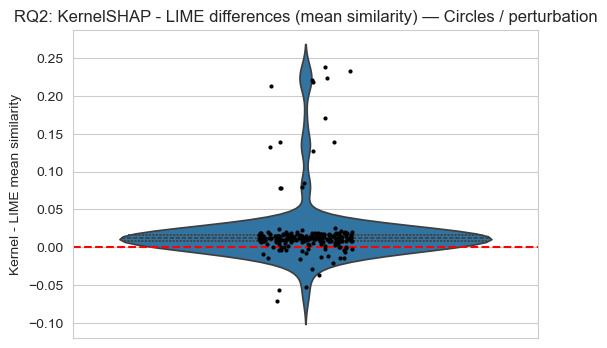

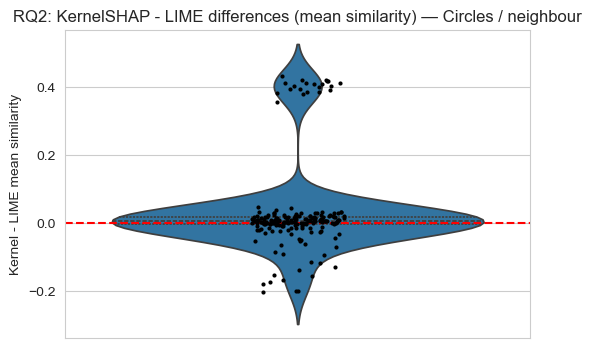

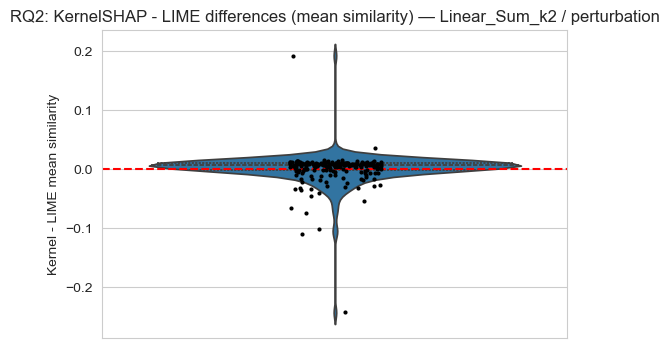

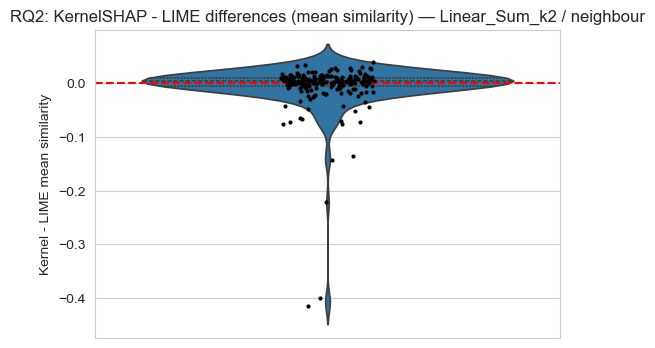

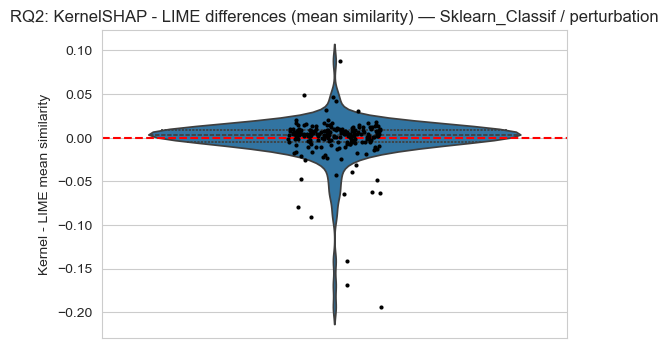

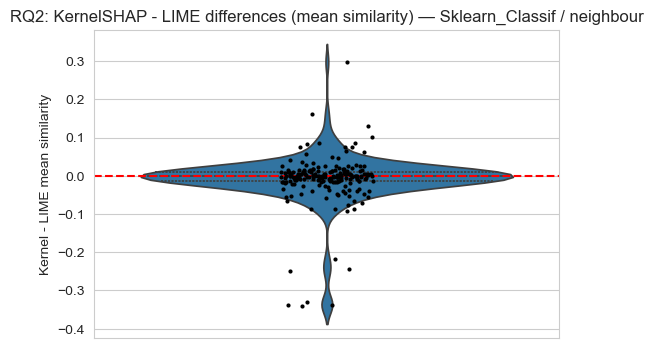

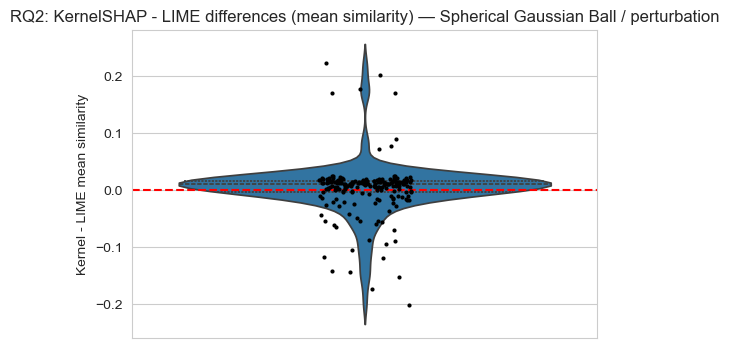

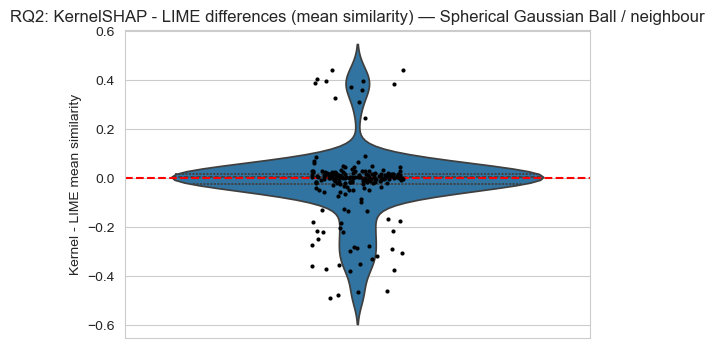

In [24]:
# Stability differences across XAI methods (paired per-instance tests)

rq2_rows = []
for ds in results_df_instances['dataset'].unique():
    for scenario in ['perturbation','neighbour']:
        sub = results_df_instances.query("dataset==@ds and scenario==@scenario")
        # pivot to aligned kernel vs lime per instance
        pivot = sub.pivot_table(index='instance_idx', columns='method', values='mean_pairwise_similarity').dropna()
        if len(pivot) < 5:
            continue
        k = pivot['kernel']
        l = pivot['lime']
        # Wilcoxon signed-rank (paired)
        stat, p = wilcoxon(k, l)
        # compute effect (mean difference)
        mean_diff = (k - l).mean()
        rq2_rows.append({
            'Dataset': ds,
            'Scenario': scenario,
            'n_pairs': len(pivot),
            'kernel_mean': k.mean(),
            'lime_mean': l.mean(),
            'mean_diff': mean_diff,
            'wilcoxon_stat': stat,
            'p_value': p.round(4)
        })

rq2_table = pd.DataFrame(rq2_rows).sort_values(['Dataset','Scenario'])
display(rq2_table)

# Visualization: paired differences violin + points
for ds in results_df_instances['dataset'].unique():
    for scenario in ['perturbation','neighbour']:
        sub = results_df_instances.query("dataset==@ds and scenario==@scenario")
        pivot = sub.pivot_table(index='instance_idx', columns='method', values='mean_pairwise_similarity').dropna()
        if len(pivot) < 5:
            continue
        diffs = pivot['kernel'] - pivot['lime']
        plt.figure(figsize=(6,4))
        sns.violinplot(data=diffs, inner='quartile')
        sns.stripplot(data=diffs, color='k', size=3, jitter=True)
        plt.axhline(0, linestyle='--', color='red')
        plt.title(f"RQ2: KernelSHAP - LIME differences (mean similarity) — {ds} / {scenario}")
        plt.ylabel("Kernel - LIME mean similarity")
        plt.show()


In [25]:
# RQ3: Does explanation similarity differ across datasets? 

methods = results_df_instances['method'].unique()
scenarios = results_df_instances['scenario'].unique()
datasets = results_df_instances['dataset'].unique()

for method in methods:
    for scenario in scenarios:
        groups = [
            results_df_instances.query("dataset==@ds & method==@method & scenario==@scenario")['mean_pairwise_similarity'].values
            for ds in datasets
        ]
        stat, p = kruskal(*groups)
        print(f"{method} | {scenario}: Kruskal-Wallis H={stat:.2f}, p={p:.3g}")

kernel | perturbation: Kruskal-Wallis H=122.79, p=1.36e-25
kernel | neighbour: Kruskal-Wallis H=149.14, p=3.12e-31
lime | perturbation: Kruskal-Wallis H=278.31, p=5.16e-59
lime | neighbour: Kruskal-Wallis H=46.05, p=2.4e-09


For all XAI methods, and perturbation scenarios, explanation similarity differs across datasets.
Let's investigate on which dataset pairs differ significantly in mean pairwise similarity.

In [26]:
# Pairwise dataset comparisons (Mann–Whitney U with Bonferroni)

methods = results_df_instances['method'].unique()
scenarios = results_df_instances['scenario'].unique()
datasets = results_df_instances['dataset'].unique()

pairwise_results = []

for method in methods:
    for scenario in scenarios:
        # all dataset pairs
        for ds1, ds2 in itertools.combinations(datasets, 2):
            a = results_df_instances.query("dataset==@ds1 & method==@method & scenario==@scenario")['mean_pairwise_similarity']
            b = results_df_instances.query("dataset==@ds2 & method==@method & scenario==@scenario")['mean_pairwise_similarity']
            # skip if either group too small
            if len(a) < 3 or len(b) < 3:
                p_val = np.nan
            else:
                _, p_val = mannwhitneyu(a, b, alternative='two-sided')
            pairwise_results.append({
                'method': method,
                'scenario': scenario,
                'dataset_a': ds1,
                'dataset_b': ds2,
                'p_raw': p_val
            })

pairwise_df = pd.DataFrame(pairwise_results)

# Bonferroni correction per method × scenario
pairwise_df['p_bonf'] = np.nan
pairwise_df['significant'] = False

for method in methods:
    for scenario in scenarios:
        mask = (pairwise_df['method']==method) & (pairwise_df['scenario']==scenario)
        pvals = pairwise_df.loc[mask, 'p_raw'].fillna(1.0).values
        if len(pvals) > 0:
            rej, p_corr, _, _ = multipletests(pvals, method='bonferroni', alpha=0.05)
            pairwise_df.loc[mask, 'p_bonf'] = p_corr
            pairwise_df.loc[mask, 'significant'] = rej

# Show only significant comparisons
sig_pairs = pairwise_df[pairwise_df['significant']].sort_values(['method','scenario','p_bonf'])
display(sig_pairs.reset_index(drop=True))

method      scenario           dataset_a                dataset_b  \
0   kernel     neighbour  Linearly_Separable            Linear_Sum_k2   
1   kernel     neighbour  Linearly_Separable                  Circles   
2   kernel     neighbour       Linear_Sum_k2  Spherical Gaussian Ball   
3   kernel     neighbour  Linearly_Separable          Sklearn_Classif   
4   kernel     neighbour       Linear_Sum_k2          Sklearn_Classif   
5   kernel     neighbour             Circles  Spherical Gaussian Ball   
6   kernel     neighbour             Circles            Linear_Sum_k2   
7   kernel  perturbation  Linearly_Separable                  Circles   
8   kernel  perturbation  Linearly_Separable            Linear_Sum_k2   
9   kernel  perturbation       Linear_Sum_k2  Spherical Gaussian Ball   
10  kernel  perturbation       Linear_Sum_k2          Sklearn_Classif   
11  kernel  perturbation  Linearly_Separable          Sklearn_Classif   
12  kernel  perturbation             Circles          Sklearn_Classif   
13  kernel  perturbation  Linearly_Separable  Spherical Gaussian Ball   
14  kernel  perturbation             Circles  Spherical Gaussian Ball   
15    lime     neighbour       Linear_Sum_k2  Spherical Gaussian Ball   
16    lime     neighbour             Circles            Linear_Sum_k2   
17    lime     neighbour  Linearly_Separable            Linear_Sum_k2   
18    lime     neighbour     Sklearn_Classif  Spherical Gaussian Ball   
19    lime     neighbour             Circles          Sklearn_Classif   
20    lime  perturbation       Linear_Sum_k2  Spherical Gaussian Ball   
21    lime  perturbation             Circles            Linear_Sum_k2   
22    lime  perturbation     Sklearn_Classif  Spherical Gaussian Ball   
23    lime  perturbation             Circles          Sklearn_Classif   
24    lime  perturbation  Linearly_Separable            Linear_Sum_k2   
25    lime  perturbation  Linearly_Separable  Spherical Gaussian Ball   
26    lime  perturbation  Linearly_Separable          Sklearn_Classif   
27    lime  perturbation  Linearly_Separable                  Circles   
28    lime  perturbation       Linear_Sum_k2          Sklearn_Classif   

           p_raw        p_bonf  significant  
0   5.376928e-25  5.376928e-24         True  
1   4.951070e-17  4.951070e-16         True  
2   2.517016e-15  2.517016e-14         True  
3   5.015932e-09  5.015932e-08         True  
4   5.449921e-09  5.449921e-08         True  
5   8.662983e-08  8.662983e-07         True  
6   4.309015e-05  4.309015e-04         True  
7   8.046263e-25  8.046263e-24         True  
8   6.642420e-18  6.642420e-17         True  
9   1.255029e-06  1.255029e-05         True  
10  2.689732e-06  2.689732e-05         True  
11  2.951556e-06  2.951556e-05         True  
12  4.203155e-06  4.203155e-05         True  
13  7.109848e-06  7.109848e-05         True  
14  1.713960e-05  1.713960e-04         True  
15  1.308978e-09  1.308978e-08         True  
16  2.161194e-06  2.161194e-05         True  
17  1.506391e-05  1.506391e-04         True  
18  5.450926e-05  5.450926e-04         True  
19  2.513720e-03  2.513720e-02         True  
20  6.829609e-48  6.829609e-47         True  
21  9.086558e-44  9.086558e-43         True  
22  2.524529e-23  2.524529e-22         True  
23  2.679382e-19  2.679382e-18         True  
24  1.860702e-12  1.860702e-11         True  
25  3.678749e-06  3.678749e-05         True  
26  1.956479e-05  1.956479e-04         True  
27  4.348044e-05  4.348044e-04         True  
28  4.547522e-03  4.547522e-02         True

Pairwise Mann-Whitney tests confirm that mean explanation similarity differs significantly across all dataset pairs for both KernelSHAP and LIME (Bonferroni-adjusted p < 0.05), in both perturbation and neighbour scenarios. This justifies exploring which dataset characteristics drive these differences.

In [27]:
# How does stability relate to dataset geometry?

sns.set(style="whitegrid", rc={"figure.dpi":120})

# 1) Compute dataset geometry metrics
dataset_rows = []
for name, gen in DATASETS:
    X, y = gen()
    geom = dataset_geometry_metrics(X, y)
    geom["dataset"] = name
    dataset_rows.append(geom)

geom_df = pd.DataFrame(dataset_rows).set_index("dataset")


# 2) Aggregate explanation similarity per dataset
#    (mean across instances, methods, scenarios)

stab_df = (
    results_df_instances
    .groupby(["dataset", "method", "scenario"])["mean_pairwise_similarity"]
    .mean()
    .reset_index()
)

# Pivot for convenience: one column per method+scenario
stab_pivot = stab_df.pivot_table(
    index="dataset",
    columns=["method", "scenario"],
    values="mean_pairwise_similarity"
)

stab_pivot.columns = [f"{m}_{s}" for m, s in stab_pivot.columns]


# 3) Join geometry metrics with stability

rq3_df = geom_df.join(stab_pivot, how="inner")
print("\nJoined table (geometry + stability):")
display(rq3_df)


# 4) Spearman correlations: geometry vs stability

geom_cols = [
    "linear_error",
    "knn_disagreement",
    "knn_entropy",
    "density_cv",
    "feature_gini",
]

stab_cols = stab_pivot.columns.tolist()

corr_rows = []
for g in geom_cols:
    for s in stab_cols:
        x = rq3_df[g]
        y = rq3_df[s]
        mask = (~x.isna()) & (~y.isna())
        if mask.sum() < 3:
            rho, p = np.nan, np.nan
        else:
            rho, p = spearmanr(x[mask], y[mask])
        corr_rows.append({
            "geometry_metric": g,
            "stability_metric": s,
            "rho": rho,
            "p": p,
            "n": int(mask.sum())
        })

corr_df = (
    pd.DataFrame(corr_rows)
    .sort_values("rho", key=lambda s: np.abs(s), ascending=False)
)

print("\nSpearman correlations (geometry ↔ stability):")
display(corr_df)


Joined table (geometry + stability):


class_entropy  linear_error  knn_disagreement  \
dataset                                                                  
Linearly_Separable            0.693115         0.012            0.0316   
Circles                       0.693147         0.487            0.0002   
Linear_Sum_k2                 0.692905         0.021            0.0332   
Sklearn_Classif               0.693139         0.063            0.0474   
Spherical Gaussian Ball       0.693147         0.475            0.0402   

                         knn_entropy  density_cv  feature_gini  \
dataset                                                          
Linearly_Separable          0.051009    0.273410      0.006207   
Circles                     0.000500    0.517756      0.113756   
Linear_Sum_k2               0.044590    0.273569      0.453914   
Sklearn_Classif             0.061396    0.830982      0.471334   
Spherical Gaussian Ball     0.062346    0.757523      0.083773   

                         kernel_neighbour  kernel_perturbation  \
dataset                                                          
Linearly_Separable               0.950304             0.979943   
Circles                          0.977391             0.992554   
Linear_Sum_k2                    0.978165             0.988494   
Sklearn_Classif                  0.967229             0.984564   
Spherical Gaussian Ball          0.929941             0.978222   

                         lime_neighbour  lime_perturbation  
dataset                                                     
Linearly_Separable             0.954442           0.977228  
Circles                        0.943595           0.972742  
Linear_Sum_k2                  0.984514           0.988251  
Sklearn_Classif                0.976794           0.986457  
Spherical Gaussian Ball        0.952848           0.976037


Spearman correlations (geometry ↔ stability):


geometry_metric     stability_metric  rho         p  n
9        knn_entropy  kernel_perturbation -0.9  0.037386  5
8        knn_entropy     kernel_neighbour -0.8  0.104088  5
2       linear_error       lime_neighbour -0.7  0.188120  5
3       linear_error    lime_perturbation -0.7  0.188120  5
16      feature_gini     kernel_neighbour  0.6  0.284757  5
19      feature_gini    lime_perturbation  0.5  0.391002  5
5   knn_disagreement  kernel_perturbation -0.5  0.391002  5
6   knn_disagreement       lime_neighbour  0.5  0.391002  5
7   knn_disagreement    lime_perturbation  0.5  0.391002  5
18      feature_gini       lime_neighbour  0.5  0.391002  5
17      feature_gini  kernel_perturbation  0.5  0.391002  5
4   knn_disagreement     kernel_neighbour -0.3  0.623838  5
1       linear_error  kernel_perturbation  0.3  0.623838  5
12        density_cv     kernel_neighbour -0.2  0.747060  5
15        density_cv    lime_perturbation -0.1  0.872889  5
10       knn_entropy       lime_neighbour  0.1  0.872889  5
14        density_cv       lime_neighbour -0.1  0.872889  5
13        density_cv  kernel_perturbation -0.1  0.872889  5
11       knn_entropy    lime_perturbation  0.1  0.872889  5
0       linear_error     kernel_neighbour  0.0  1.000000  5

<Figure size 960x480 with 0 Axes>

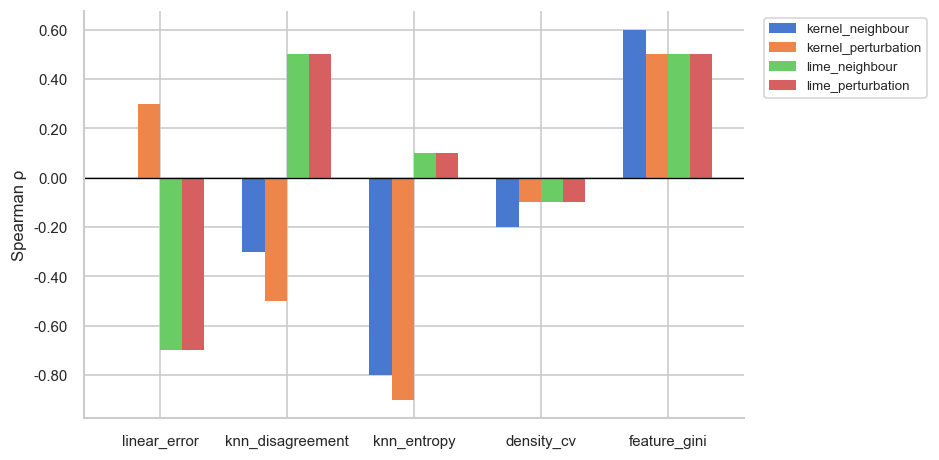


Top geometry–stability relationships:


geometry_metric     stability_metric  rho         p  n
9     knn_entropy  kernel_perturbation -0.9  0.037386  5
8     knn_entropy     kernel_neighbour -0.8  0.104088  5

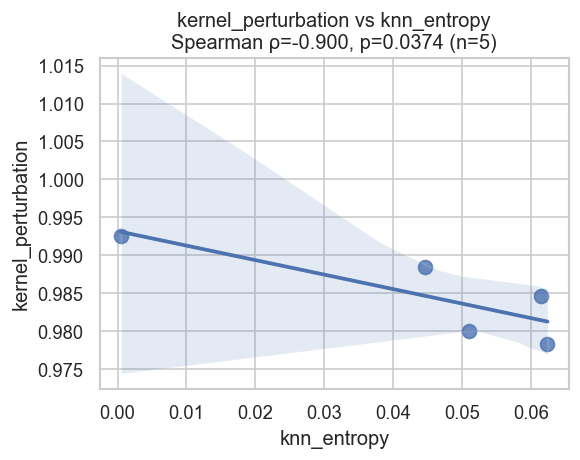

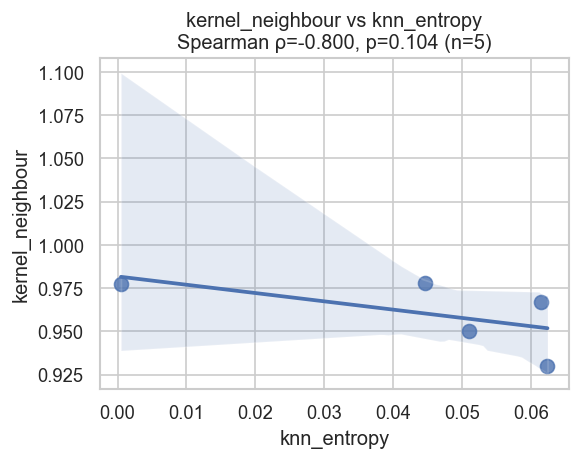

In [28]:
plt.figure(figsize=(8,4))

# Prepare data
plot_tbl = corr_df.pivot(
    index="geometry_metric",
    columns="stability_metric",
    values="rho"
).reindex(geom_cols)

# Use muted color palette
colors = sns.color_palette("muted", n_colors=len(plot_tbl.columns))

# Plot
ax = plot_tbl.plot(
    kind="bar",
    color=colors,
    edgecolor='none',
    width=0.7,
    figsize=(8,4)
)

# Style adjustments for LNCS-paper style
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("Spearman ρ", fontsize=10)
ax.set_xlabel("")
ax.set_xticklabels(plot_tbl.index, rotation=0, fontsize=9)
ax.tick_params(axis='y', labelsize=9)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

# Legend outside
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=8
)

plt.tight_layout()
plt.show()


# 6) Scatter plots for the strongest effects (top |rho|)

top_pairs = corr_df.dropna(subset=["rho"]).head(2)

print("\nTop geometry–stability relationships:")
display(top_pairs)

for _, row in top_pairs.iterrows():
    g = row["geometry_metric"]
    s = row["stability_metric"]
    rho, p, n = row["rho"], row["p"], row["n"]

    plt.figure(figsize=(5,4))
    sns.regplot(
        x=rq3_df[g],
        y=rq3_df[s],
        scatter_kws={"s":70}
    )
    plt.xlabel(g)
    plt.ylabel(s)
    plt.title(f"{s} vs {g}\nSpearman ρ={rho:.3f}, p={p:.3g} (n={n})")
    plt.tight_layout()
    plt.show()

**RQ3 — Relationship between dataset geometry and explanation similarity**

Does explanation similarity differ across datasets? If so, how does stability relate to dataset geometry?

- **Local label uncertainty (kNN entropy) is the strongest driver of instability**: Higher knn_entropy shows a strong negative correlation with KernelSHAP stability (ρ ≈ −0.9 for perturbation, −0.8 for neighbour), indicating that explanations become much less similar in locally ambiguous regions. Nevertheless, LIME doesn't suffer so much from this uncertainty. 

- **Decision boundary non-linearity reduces LIME stability**: Higher linear_error (more non-linear boundaries) is consistently associated with lower explanation similarity for LIME (ρ ≈ −0.7 for both neighbour and perturbation scenarios). KernelSHAP's explanations, on the other hand, don't suffer from non-linearity.

- **Feature dominance improves stability**: Higher feature_gini (one feature dominating the decision) correlates positively with explanation similarity, especially for KernelSHAP and LIME perturbation, suggesting sparse decision structures obtain more consistent explanations.

- **Local label disagreement has mixed effects**: knn_disagreement shows moderate correlations with stability (|ρ| ≈ 0.5) for both KernelSHAP and LIME, indicating that neighborhood-level label flips affect explanation similarity, but less strongly than label entropy.

- **Density heterogeneity has limited impact in this setting**: density_cv shows weak correlations with explanation similarity across all methods and scenarios, suggesting density effects are secondary for these two-dimensional synthetic datasets.

- **Method sensitivity differs by geometry**: KernelSHAP is primarily affected by local label uncertainty, while LIME is more sensitive to global boundary non-linearity, suggesting distinct instability modes across explanation methods.

dataset      scenario  method  spearman_rho  spearman_p  \
6                   Circles     neighbour  kernel      0.158263      0.0252   
7                   Circles     neighbour    lime      0.212342      0.0025   
4                   Circles  perturbation  kernel      0.297885      0.0000   
5                   Circles  perturbation    lime      0.011464      0.8720   
10            Linear_Sum_k2     neighbour  kernel      0.461913      0.0000   
11            Linear_Sum_k2     neighbour    lime     -0.048338      0.4967   
8             Linear_Sum_k2  perturbation  kernel      0.704766      0.0000   
9             Linear_Sum_k2  perturbation    lime     -0.125498      0.0766   
2        Linearly_Separable     neighbour  kernel      0.333751      0.0000   
3        Linearly_Separable     neighbour    lime      0.040359      0.5704   
0        Linearly_Separable  perturbation  kernel      0.544987      0.0000   
1        Linearly_Separable  perturbation    lime      0.094320      0.1840   
14          Sklearn_Classif     neighbour  kernel      0.612787      0.0000   
15          Sklearn_Classif     neighbour    lime      0.147661      0.0369   
12          Sklearn_Classif  perturbation  kernel      0.586294      0.0000   
13          Sklearn_Classif  perturbation    lime      0.233682      0.0009   
18  Spherical Gaussian Ball     neighbour  kernel      0.529808      0.0000   
19  Spherical Gaussian Ball     neighbour    lime      0.037772      0.5954   
16  Spherical Gaussian Ball  perturbation  kernel      0.694103      0.0000   
17  Spherical Gaussian Ball  perturbation    lime     -0.032984      0.6429   

    linreg_slope  linreg_p_two_sided  linreg_p_one_sided  
6       0.233371              0.1496              0.0748  
7       0.898647              0.0475              0.0238  
4       0.256900              0.0000              0.0000  
5       0.061072              0.6963              0.3481  
10      0.685489              0.0000              0.0000  
11      0.211466              0.0002              0.0001  
8       0.313519              0.0000              0.0000  
9       0.070496              0.0002              0.0001  
2       0.359399              0.0000              0.0000  
3       0.039790              0.4549              0.2274  
0       0.177745              0.0000              0.0000  
1       0.038200              0.0243              0.0122  
14      0.653112              0.0000              0.0000  
15      0.151813              0.0036              0.0018  
12      0.267322              0.0000              0.0000  
13      0.025755              0.0161              0.0080  
18      0.704514              0.0000              0.0000  
19     -0.014972              0.8466              0.5767  
16      0.332670              0.0000              0.0000  
17      0.018628              0.4408              0.2204

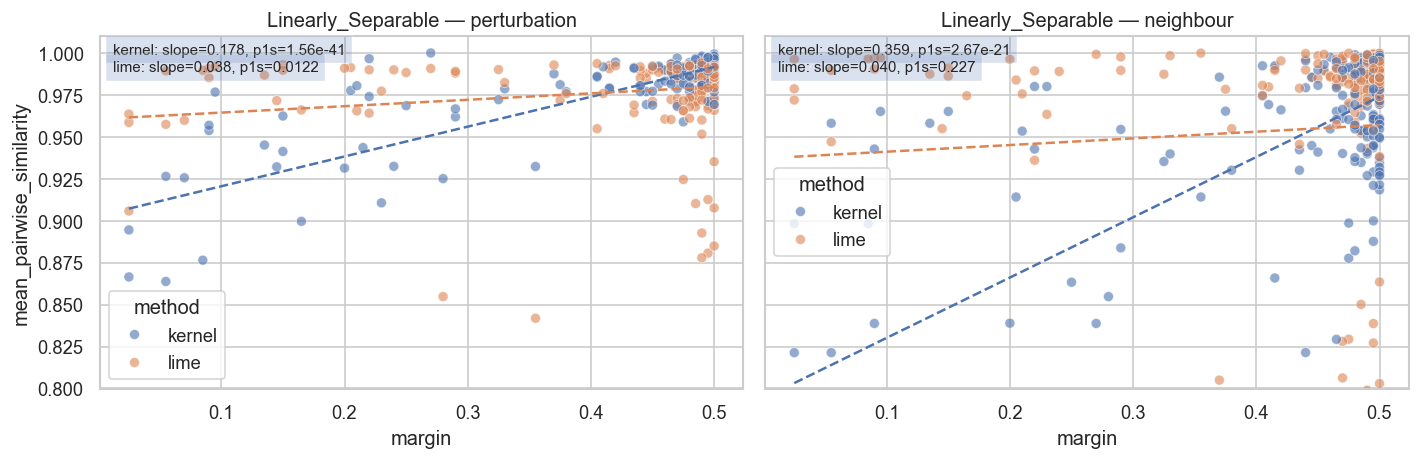

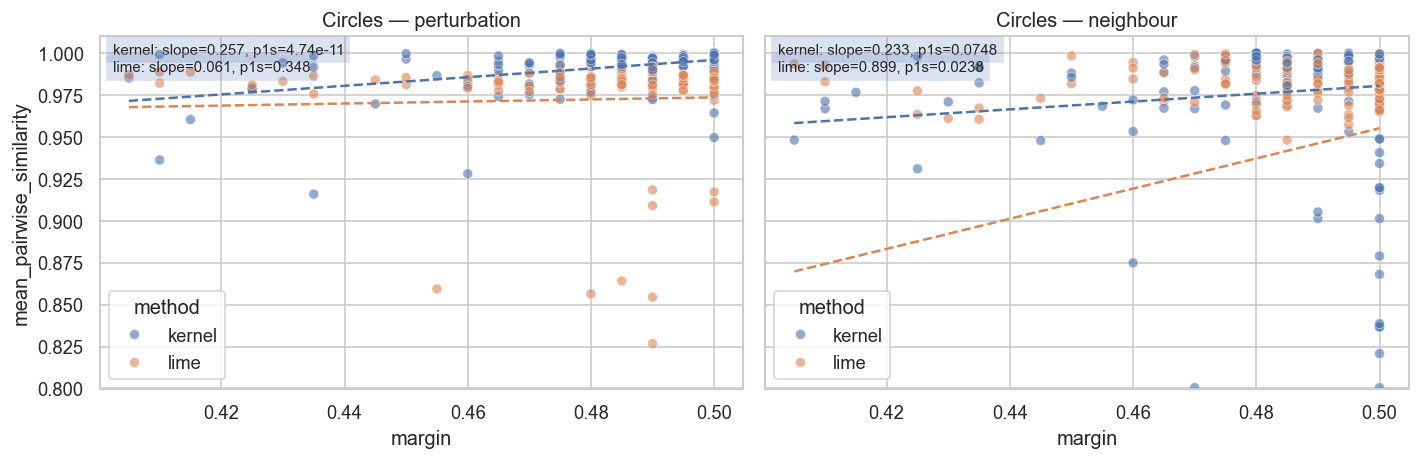

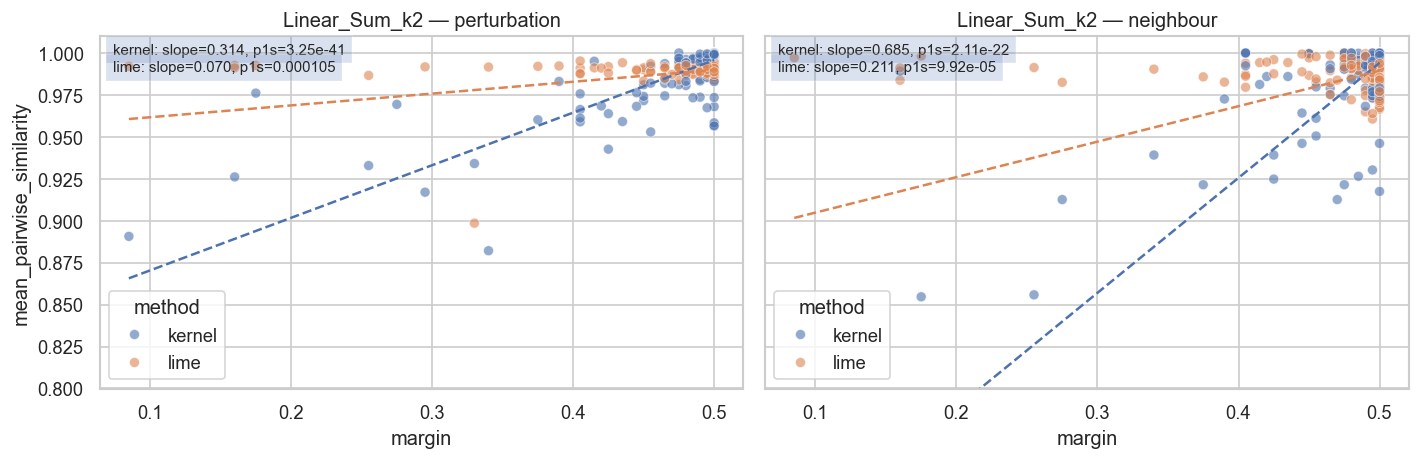

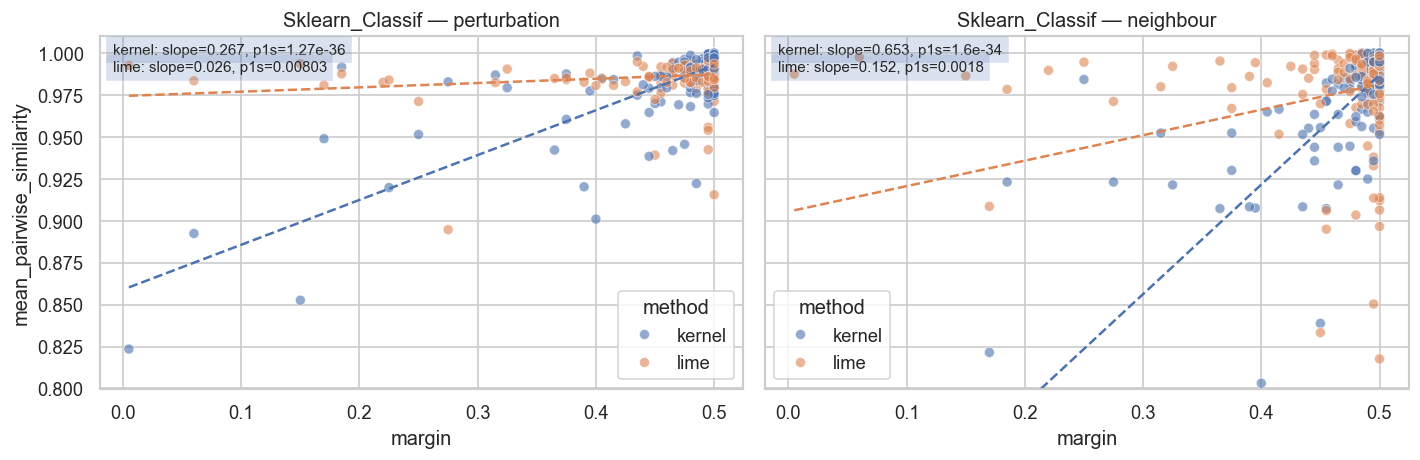

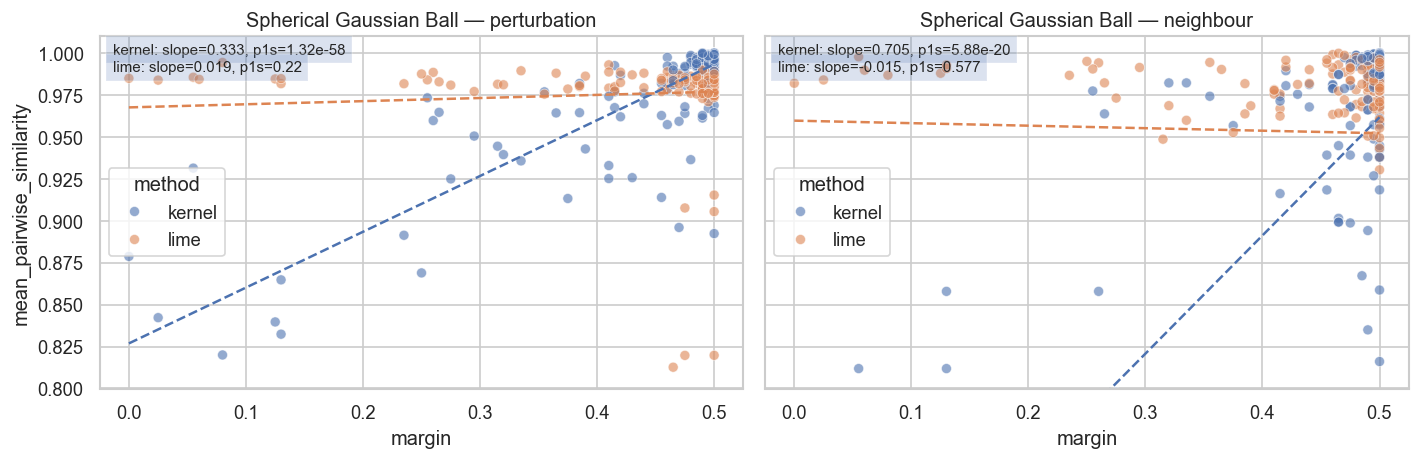

In [29]:
# Stability vs prediction uncertainty

# Function to compute one-sided p-value for positive slope
def one_sided_p(slope, p_two_sided):
    if slope > 0:
        return p_two_sided / 2
    else:
        return 1 - p_two_sided / 2

# Collect results
rq4_rows = []
for ds in results_df_instances['dataset'].unique():
    for scenario in ['perturbation','neighbour']:
        sub = results_df_instances.query("dataset==@ds and scenario==@scenario")
        if sub.shape[0] < 5:
            continue
        # Spearman correlation per method
        for method in ['kernel','lime']:
            sm = sub[sub['method']==method]
            if len(sm) < 5:
                continue
            rho, p_spearman = spearmanr(sm['margin'], sm['mean_pairwise_similarity'])
            # Linear regression (for slope & p-value)
            lr = linregress(sm['margin'], sm['mean_pairwise_similarity'])
            p_one_sided = one_sided_p(lr.slope, lr.pvalue)
            rq4_rows.append({
                'dataset': ds,
                'scenario': scenario,
                'method': method,
                'spearman_rho': rho,
                'spearman_p': p_spearman.round(4),
                'linreg_slope': lr.slope,
                'linreg_p_two_sided': lr.pvalue.round(4),
                'linreg_p_one_sided': p_one_sided.round(4)
            })

# Create table
rq4_table = pd.DataFrame(rq4_rows).sort_values(['dataset','scenario','method'])
display(rq4_table)

# Plotting: scatter + regression lines
for ds in results_df_instances['dataset'].unique():
    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    for j, scenario in enumerate(['perturbation','neighbour']):
        ax = axes[j]
        sub = results_df_instances.query("dataset==@ds and scenario==@scenario")
        if sub.empty:
            ax.set_title(f"{scenario} - no data")
            continue
        sns.scatterplot(data=sub, x='margin', y='mean_pairwise_similarity', hue='method', alpha=0.6, ax=ax)
        for method in ['kernel','lime']:
            sm = sub[sub['method']==method]
            if len(sm) > 2:
                lr = linregress(sm['margin'], sm['mean_pairwise_similarity'])
                x0 = sm['margin'].min()
                x1 = sm['margin'].max()
                ax.plot([x0,x1], [lr.slope*x0 + lr.intercept, lr.slope*x1 + lr.intercept],
                        linestyle='--', label=f"{method} trend")
                # Compute one-sided p-value
                p_one_sided = one_sided_p(lr.slope, lr.pvalue)
                ax.text(0.02, 0.95 - 0.05*(0 if method=='kernel' else 1),
                        f"{method}: slope={lr.slope:.3f}, p1s={p_one_sided:.3g}",
                        transform=ax.transAxes, fontsize=9, bbox=dict(alpha=0.2))
        ax.set_ylim(0.8,1.01)
        ax.set_title(f"{ds} — {scenario}")
    plt.tight_layout()
    plt.show()

In [30]:
rq4_table[rq4_table["spearman_p"] > 0.05]

dataset      scenario method  spearman_rho  spearman_p  \
5                   Circles  perturbation   lime      0.011464      0.8720   
11            Linear_Sum_k2     neighbour   lime     -0.048338      0.4967   
9             Linear_Sum_k2  perturbation   lime     -0.125498      0.0766   
3        Linearly_Separable     neighbour   lime      0.040359      0.5704   
1        Linearly_Separable  perturbation   lime      0.094320      0.1840   
19  Spherical Gaussian Ball     neighbour   lime      0.037772      0.5954   
17  Spherical Gaussian Ball  perturbation   lime     -0.032984      0.6429   

    linreg_slope  linreg_p_two_sided  linreg_p_one_sided  
5       0.061072              0.6963              0.3481  
11      0.211466              0.0002              0.0001  
9       0.070496              0.0002              0.0001  
3       0.039790              0.4549              0.2274  
1       0.038200              0.0243              0.0122  
19     -0.014972              0.8466              0.5767  
17      0.018628              0.4408              0.2204

In some lime cases, Spearman correlation is non-significant, but slope is positive and one-sided p < 0.05.

Explanation: Spearman measures monotonicity, while regression measures linear trend magnitude. If the relationship is weakly monotonic but has a linear slope, these metrics can diverge.

Negative slopes or non-significant one-sided p-values indicate no clear trend, particularly for LIME.

In [31]:
rq4_table[rq4_table["method"]=="kernel"]

dataset      scenario  method  spearman_rho  spearman_p  \
6                   Circles     neighbour  kernel      0.158263      0.0252   
4                   Circles  perturbation  kernel      0.297885      0.0000   
10            Linear_Sum_k2     neighbour  kernel      0.461913      0.0000   
8             Linear_Sum_k2  perturbation  kernel      0.704766      0.0000   
2        Linearly_Separable     neighbour  kernel      0.333751      0.0000   
0        Linearly_Separable  perturbation  kernel      0.544987      0.0000   
14          Sklearn_Classif     neighbour  kernel      0.612787      0.0000   
12          Sklearn_Classif  perturbation  kernel      0.586294      0.0000   
18  Spherical Gaussian Ball     neighbour  kernel      0.529808      0.0000   
16  Spherical Gaussian Ball  perturbation  kernel      0.694103      0.0000   

    linreg_slope  linreg_p_two_sided  linreg_p_one_sided  
6       0.233371              0.1496              0.0748  
4       0.256900              0.0000              0.0000  
10      0.685489              0.0000              0.0000  
8       0.313519              0.0000              0.0000  
2       0.359399              0.0000              0.0000  
0       0.177745              0.0000              0.0000  
14      0.653112              0.0000              0.0000  
12      0.267322              0.0000              0.0000  
18      0.704514              0.0000              0.0000  
16      0.332670              0.0000              0.0000

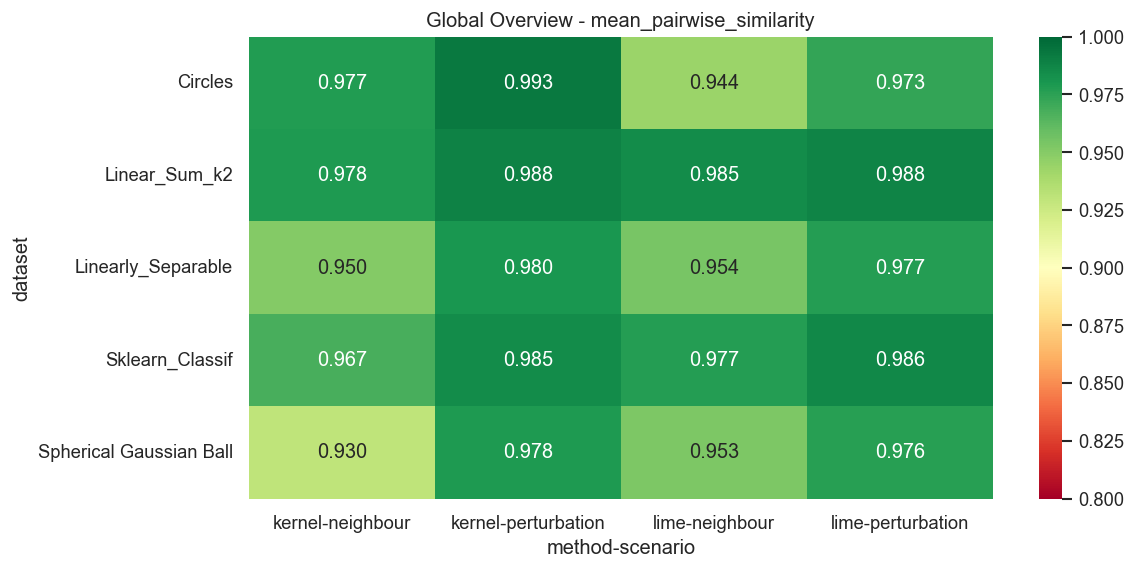

In [32]:
# Cell 13 - Heatmap of mean similarities

heat_df = results_df_instances.groupby(['dataset','method','scenario'])['mean_pairwise_similarity'].mean().reset_index()
heat_pivot = heat_df.pivot_table(index='dataset', columns=['method','scenario'], values='mean_pairwise_similarity')
plt.figure(figsize=(10,5))
sns.heatmap(heat_pivot, annot=True, fmt=".3f", vmin=0.8, vmax=1.0, cmap='RdYlGn')
plt.title("Global Overview - mean_pairwise_similarity")
plt.show()